In [83]:
import math
import random
import numpy as np
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import movecolumn as mc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

plt.rcParams['figure.figsize'] = [14, 3]


# Предобработка данных

Dataset from: https://github.com/itmo-ml-lab-ML-course/parser-imorda

In [84]:
raw_df = pd.read_csv('data/result.csv')
raw_df

Unnamed: 0                         name body_type modification_name  \
0               0        Nissan Gloria X (Y33)     Седан            2.0 AT   
1               1        Nissan Gloria X (Y33)     Седан            2.5 AT   
2               2        Nissan Gloria X (Y33)     Седан            2.5 AT   
3               3        Nissan Gloria X (Y33)     Седан            3.0 AT   
4               4        Nissan Gloria X (Y33)     Седан            3.0 AT   
...           ...                          ...       ...               ...   
58279       58279  Toyota Avensis I Рестайлинг   Лифтбек            2.0 AT   
58280       58280            Toyota Avensis II     Седан            2.2 MT   
58281       58281            Toyota Avensis II   Лифтбек            1.8 AT   
58282       58282            Toyota Avensis II     Седан            2.2 MT   
58283       58283  Toyota Avensis I Рестайлинг   Лифтбек            2.0 AT   

       price_min  price_max country classe  doors_count  seats_count  ...  \
0             -1         -1  Япония      E            4            5  ...   
1         230000     230000  Япония      E            4            5  ...   
2             -1         -1  Япония      E            4            5  ...   
3             -1         -1  Япония      E            4            5  ...   
4             -1         -1  Япония      E            4            5  ...   
...          ...        ...     ...    ...          ...          ...  ...   
58279         -1         -1  Япония      D            5            5  ...   
58280         -1         -1  Япония      D            4            5  ...   
58281         -1         -1  Япония      D            5            5  ...   
58282         -1         -1  Япония      D            4            5  ...   
58283         -1         -1  Япония      D            5            5  ...   

      engine_max_power_rpm engine_max_torque engine_max_torque_rpm  \
0                     6000               167                  3200   
1                     6400               235                  4000   
2                     6400               275                  4800   
3                     5200               248                  3200   
4                     6000               368                  3600   
...                    ...               ...                   ...   
58279                 5700               200                  4000   
58280                 3600               310                  2000   
58281                 6000               170                  4200   
58282                 3600               310                  2000   
58283                 5400               178                  4400   

      engine_cylinders_position engine_cylinders_count  \
0                    V-образное                      6   
1                    V-образное                      6   
2                        рядное                      6   
3                    V-образное                      6   
4                    V-образное                      6   
...                         ...                    ...   
58279                    рядное                      4   
58280                    рядное                      4   
58281                    рядное                      4   
58282                    рядное                      4   
58283                    рядное                      4   

       engine_valves_per_cylinder                     engine_intake_type  \
0                              -1  распределенный впрыск (многоточечный)   
1                               4  распределенный впрыск (многоточечный)   
2                               4  распределенный впрыск (многоточечный)   
3                               2  распределенный впрыск (многоточечный)   
4                               4       непосредственный впрыск (прямой)   
...                           ...                                    ...   
58279                           4  распределенный впрыск (многоточечный)   

Кайф, 54 параметра. Предстоит найти в них небесполезные признаки....

Попробуем предсказывать цену автомобиля по его каталожным параметрам

<Axes: >

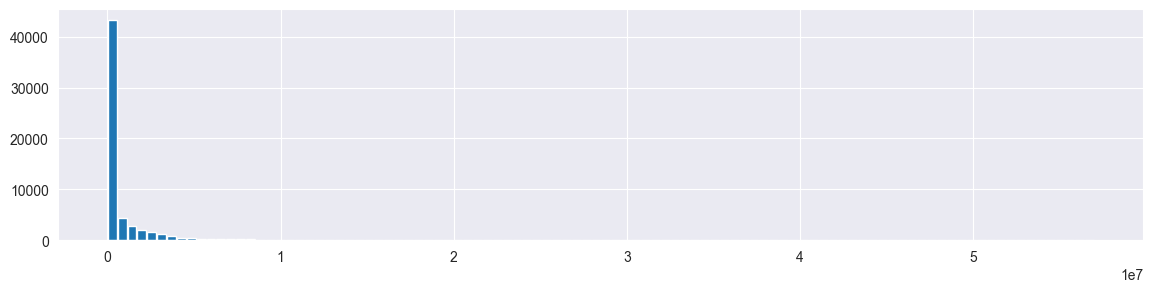

In [85]:
raw_df.price_min.hist(bins=100, rwidth=0.9)

Для начала потрём данные, в которых нет цены, так как её и будем предсказывать (как в train, так и в test выборке нужна цена, надо же как-то что-то валидировать

Замечание: как price_min так и price_max могут быть страшными выбросами, так как низ рынка, как и верх иногда могут неоправдано улетать в космос. Хочется взять медиану рынка, но у нас всего 2 признака (мин и макс). Что ж, остаётся только взять среднее, чтобы хоть как-то с этим справиться.


<Axes: >

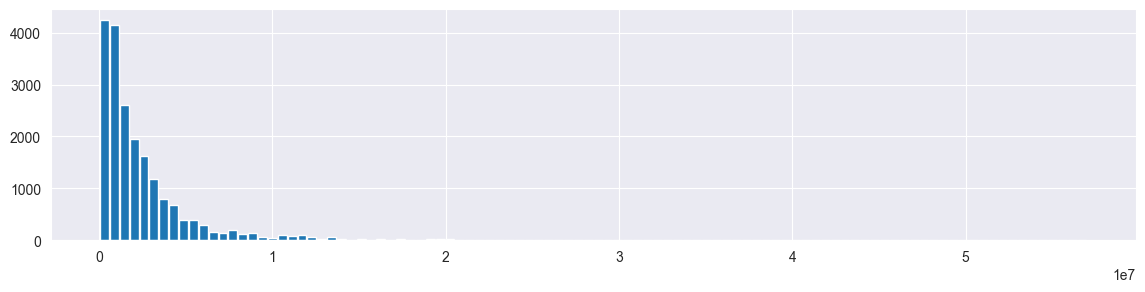

In [86]:
raw_df['price_avg'] = raw_df.price_min + (raw_df.price_max - raw_df.price_min) / 2.

df = raw_df[(raw_df.price_min > 0) & 
            (raw_df.price_max > 0) &
            (raw_df.doors_count > 0)]
df.price_avg.hist(bins=100, rwidth=0.9)

In [87]:
df

Unnamed: 0                    name body_type modification_name  \
1               1   Nissan Gloria X (Y33)     Седан            2.5 AT   
9               9   Nissan Gloria X (Y33)     Седан            2.8 AT   
60             60  Nissan Gloria XI (Y34)     Седан            3.0 AT   
63             63  Nissan Gloria XI (Y34)     Седан           3.0 CVT   
64             64  Nissan Gloria XI (Y34)     Седан            2.5 AT   
...           ...                     ...       ...               ...   
58264       58264       Toyota Avensis II     Седан            1.8 AT   
58266       58266       Toyota Avensis II     Седан            2.0 MT   
58267       58267       Toyota Avensis II     Седан            2.0 AT   
58268       58268       Toyota Avensis II     Седан            1.8 MT   
58275       58275       Toyota Avensis II     Седан            2.0 AT   

       price_min  price_max country classe  doors_count  seats_count  ...  \
1         230000     230000  Япония      E            4            5  ...   
9         820000     820000  Япония      E            4            5  ...   
60        510000     510000  Япония      E            4            5  ...   
63        510000     510000  Япония      E            4            5  ...   
64        548000     690000  Япония      E            4            5  ...   
...          ...        ...     ...    ...          ...          ...  ...   
58264     600000     600000  Япония      D            4            5  ...   
58266     610000     610000  Япония      D            4            5  ...   
58267     610000     610000  Япония      D            4            5  ...   
58268     600000     600000  Япония      D            4            5  ...   
58275     610000     610000  Япония      D            4            5  ...   

      engine_max_torque engine_max_torque_rpm engine_cylinders_position  \
1                   235                  4000                V-образное   
9                   181                  2400                    рядное   
60                  387                  3600                V-образное   
63                  387                  3600                V-образное   
64                  265                  4400                V-образное   
...                 ...                   ...                       ...   
58264               170                  4200                    рядное   
58266               196                  4000                    рядное   
58267               196                  4000                    рядное   
58268               170                  4200                    рядное   
58275               192                  4000                    рядное   

      engine_cylinders_count engine_valves_per_cylinder  \
1                          6                          4   
9                          6                          2   
60                         6                          4   
63                         6                          4   
64                         6                          4   
...                      ...                        ...   
58264                      4                          4   
58266                      4                          4   
58267                      4                          4   
58268                      4                          4   
58275                      4                          4   

                          engine_intake_type  engine_compression  \
1      распределенный впрыск (многоточечный)                10.0   
9                              ТНВД (Дизель)                22.0   
60          непосредственный впрыск (прямой)                 9.0   
63          непосредственный впрыск (прямой)                 9.0   
64          непосредственный впрыск (прямой)                11.0   
...                                      ...                 ...   
58264  распределенный впрыск (многоточечный)                10.0   
58266       непосредственный впрыск (прямой)       

Слишком большой разброс цен, ничего не видно. Окэй, логарифмируем

<Axes: >

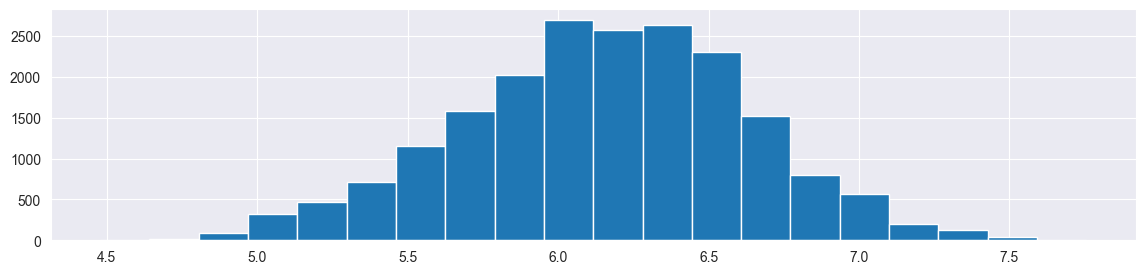

In [88]:
price = df.price_avg
price_log = np.log10(price)
price_log.hist(bins=20)

Omg, это же нормальное распределение, кайф. 
Ну мы поняли, что большинство тачек стоит где-то 1-5 лимонов, супер.

Лан, это вполне возможно предсказывать. 

Теперь задача вытащить из этой свалки полезные фичи...

In [89]:
df.dtypes

Unnamed: 0                      int64
name                           object
body_type                      object
modification_name              object
price_min                       int64
price_max                       int64
country                        object
classe                         object
doors_count                     int64
seats_count                     int64
steering_wheel_side            object
front_suspension_type          object
rear_suspension_type           object
front_brakes_type              object
rear_brakes_type               object
length                          int64
width                           int64
height                          int64
wheelbase                       int64
clearance                       int64
front_track                     int64
rear_track                      int64
max_speed                       int64
zero_to_100                   float64
fuel_consumption_city         float64
fuel_consumption_road         float64
fuel_consump

В целом, можно парсить и onehotить имя, вытаскивая название марки. Всякие мерседесы ожидаются быть более дорогими, чем ВАЗ. Однако, это довольно тупая фича получается, так как мы не можем ограничиться парой марок, лучше смотреть на более прямые признаки (например, класс автомобиля, который в свою очередь не помешает отonehotить)

In [90]:
processed_df = pd.DataFrame()

### Численные признаки

#### Количество дверей

<Axes: >

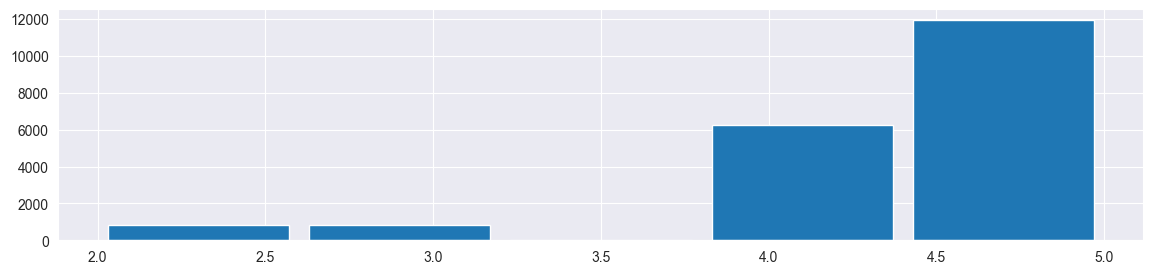

In [91]:
processed_df['doors_count'] = df.doors_count
processed_df.doors_count.hist(bins=5, rwidth=0.9)

#### Количество мест

<Axes: >

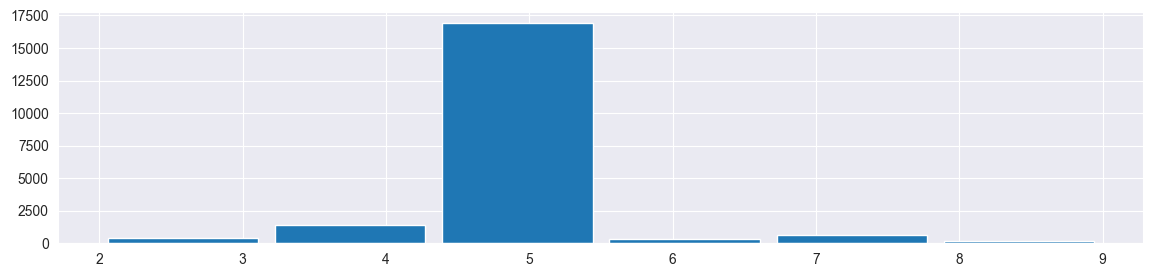

In [92]:
processed_df['seats_count'] = df.seats_count
processed_df.seats_count.hist(bins=6, rwidth=0.9)

#### Длина

<Axes: >

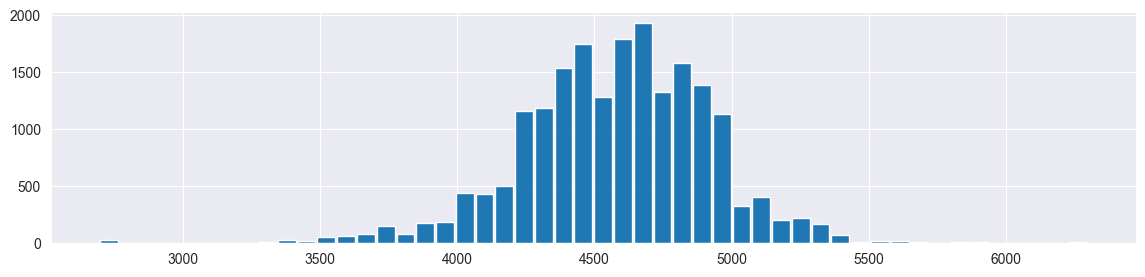

In [93]:
processed_df['length'] = df.length
processed_df.length.hist(bins=50, rwidth=0.9)

#### Ширина

<Axes: >

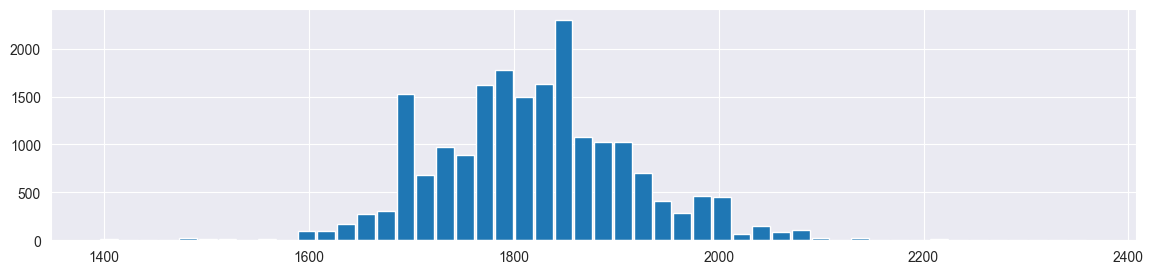

In [94]:
processed_df['width'] = df.width
processed_df.width.hist(bins=50, rwidth=0.9)

#### Высота

<Axes: >

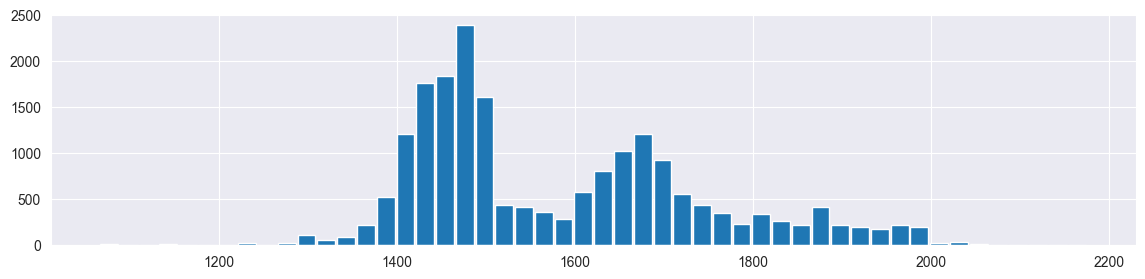

In [95]:
processed_df['height'] = df.height
processed_df.height.hist(bins=50, rwidth=0.9)

#### Колёсная база

<Axes: >

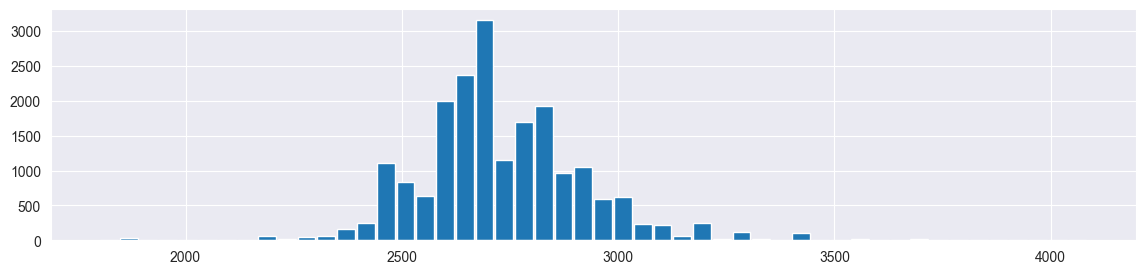

In [96]:
processed_df['wheelbase'] = df.wheelbase
processed_df.wheelbase.hist(bins=50, rwidth=0.9)

#### Клиренс

<Axes: >

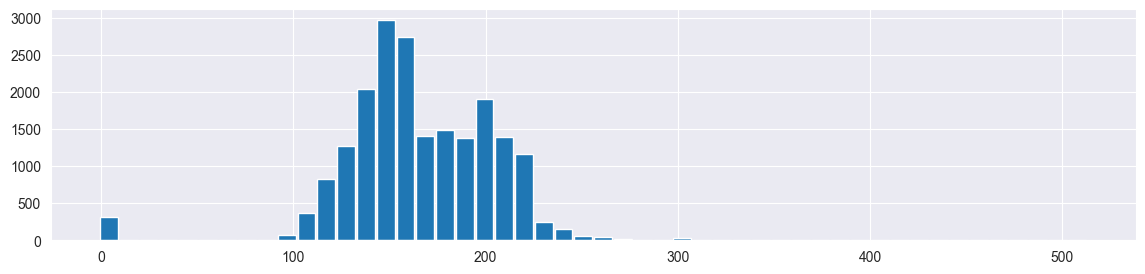

In [97]:
processed_df['clearance'] = df.clearance
processed_df.clearance.hist(bins=50, rwidth=0.9)

#### Передняя колея

<Axes: >

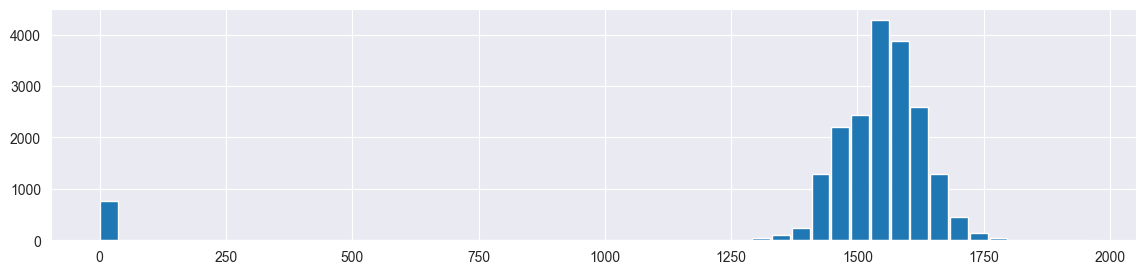

In [98]:
processed_df['front_track'] = df.front_track
processed_df.front_track.hist(bins=50, rwidth=0.9)

#### Задняя колея

<Axes: >

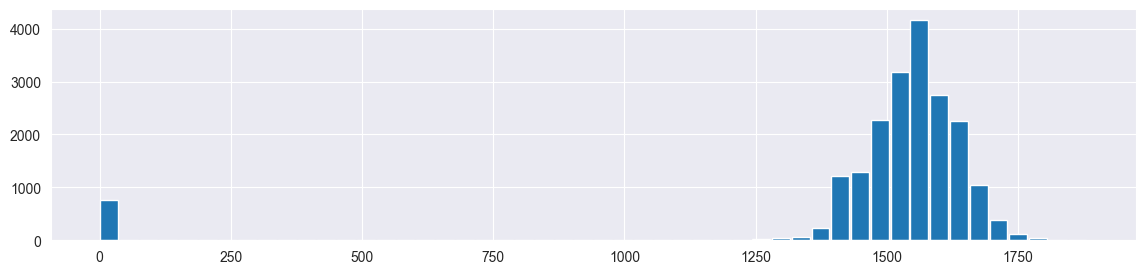

In [99]:
processed_df['rear_track'] = df.rear_track
processed_df.rear_track.hist(bins=50, rwidth=0.9)

#### Максимальная скорость

<Axes: >

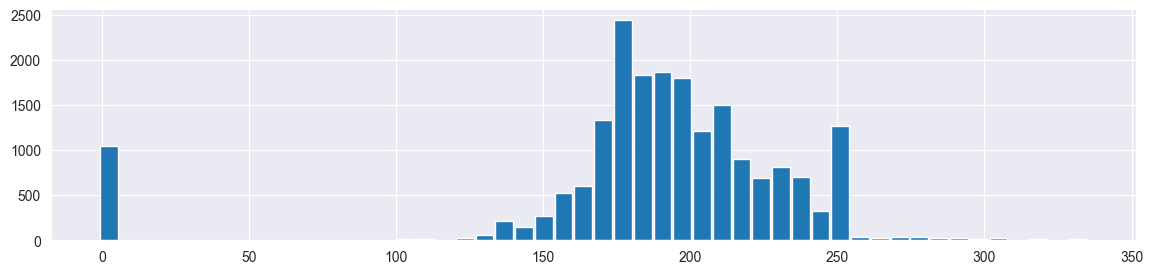

In [100]:
processed_df['max_speed'] = df.max_speed
processed_df.max_speed.hist(bins=50, rwidth=0.9)

#### Разгон до 100

<Axes: >

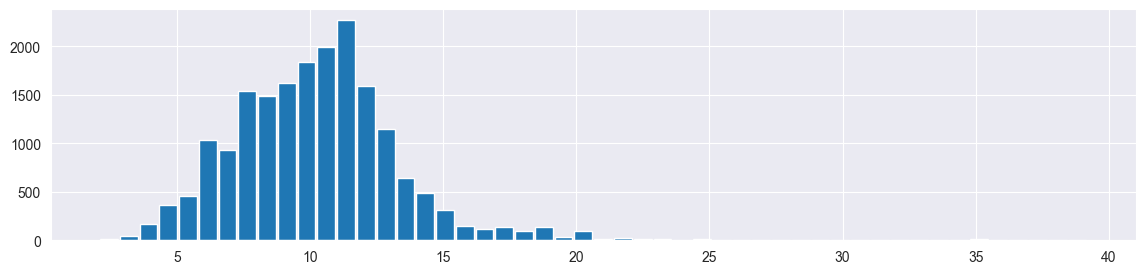

In [101]:
processed_df['zero_to_100'] = df.zero_to_100
processed_df.zero_to_100.hist(bins=50, rwidth=0.9)

#### Смешанный расход топлива

<Axes: >

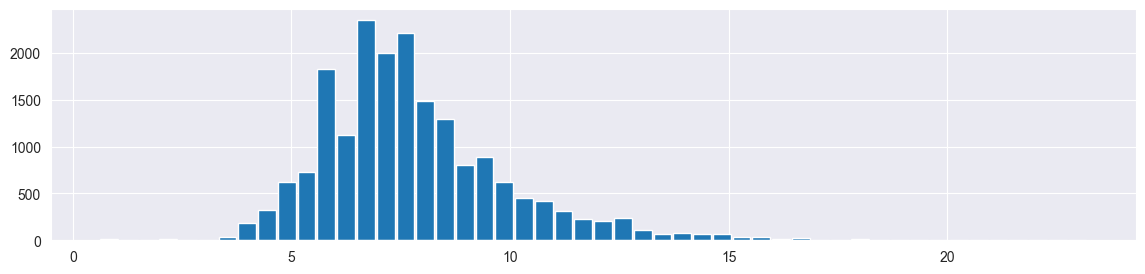

In [102]:
processed_df['fuel_consumption_mixed'] = df.fuel_consumption_mixed
processed_df.fuel_consumption_mixed.hist(bins=50, rwidth=0.9)

#### Объём двигателя

<Axes: >

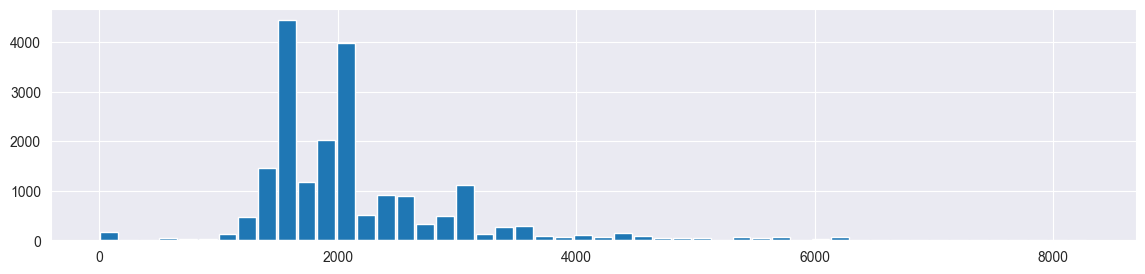

In [103]:
processed_df['engine_displacement'] = df.engine_displacement
processed_df.engine_displacement.hist(bins=50, rwidth=0.9)

#### Мощность двигателя

<Axes: >

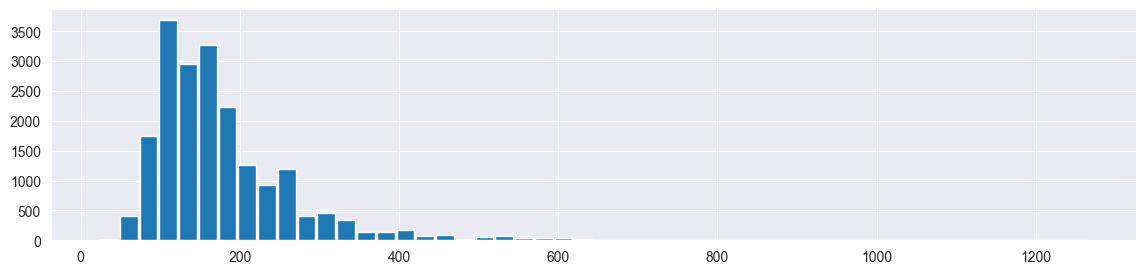

In [104]:
processed_df['engine_max_horsepower'] = df.engine_max_horsepower
processed_df.engine_max_horsepower.hist(bins=50, rwidth=0.9)

#### Крутящий момент двигателя

<Axes: >

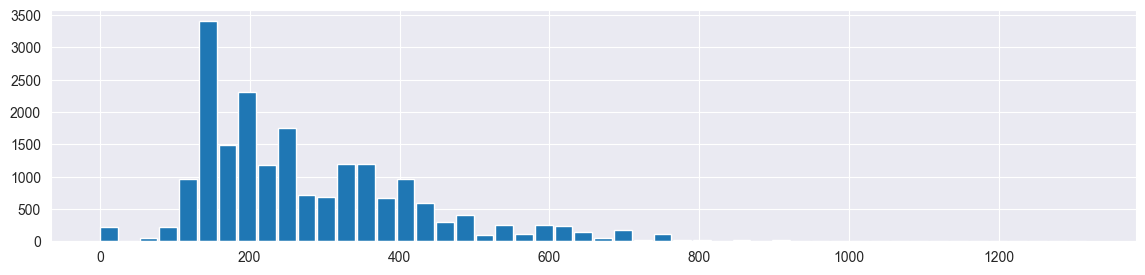

In [105]:
processed_df['engine_max_torque'] = df.engine_max_torque
processed_df.engine_max_torque.hist(bins=50, rwidth=0.9)

#### Количество цилиндров в двигателе

<Axes: >

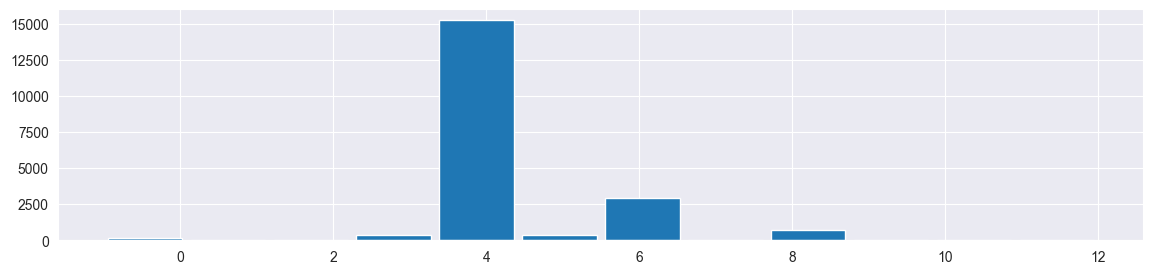

In [106]:
processed_df['engine_cylinders_count'] = df.engine_cylinders_count
processed_df.engine_cylinders_count.hist(bins=12, rwidth=0.9)

#### Средняя цена

<Axes: >

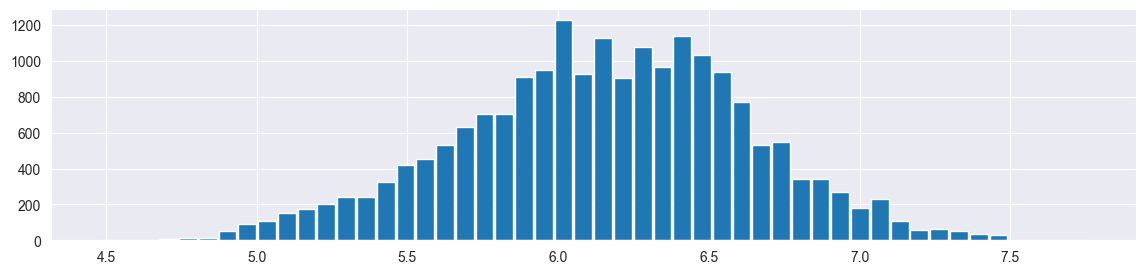

In [107]:
processed_df['price_avg'] = price_log
processed_df.price_avg.hist(bins=50, rwidth=0.9)

### Target

#### Тип привода

Тут хотим сделать label encoding, чтобы сделать из этого признака target. Хорошо ложится на kNN, где не бывает промежуточных значений результата

In [108]:
le = LabelEncoder()
df.drive_type.replace('задний', 'неполный', inplace=True)
df.drive_type.replace('передний', 'неполный', inplace=True)
le.fit(df.drive_type)
le.classes_

C:\Users\btima\AppData\Local\Temp\ipykernel_26236\1825294690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drive_type.replace('задний', 'неполный', inplace=True)
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\1825294690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drive_type.replace('передний', 'неполный', inplace=True)


array(['неполный', 'полный'], dtype=object)

In [109]:
processed_df['target'] = le.transform(df.drive_type)
processed_df.target *= 2
processed_df.target -= 1
processed_df

doors_count  seats_count  length  width  height  wheelbase  clearance  \
1                4            5    4860   1720    1425       2735        145   
9                4            5    4860   1720    1425       2735        145   
60               4            5    4865   1770    1180       2800        140   
63               4            5    4865   1770    1180       2800        140   
64               4            5    4865   1770    1180       2800        140   
...            ...          ...     ...    ...     ...        ...        ...   
58264            4            5    4630   1760    1480       2700        150   
58266            4            5    4630   1760    1480       2700        150   
58267            4            5    4630   1760    1480       2700        150   
58268            4            5    4630   1760    1480       2700        150   
58275            4            5    4630   1760    1480       2700        150   

       front_track  rear_track  max_speed  zero_to_100  \
1             1440        1450         -1          NaN   
9             1440        1450         -1          NaN   
60            1510        1510        251          6.8   
63            1510        1510        245          6.6   
64            1510        1510        180          8.8   
...            ...         ...        ...          ...   
58264         1505        1510        185         11.6   
58266         1505        1510        205          9.4   
58267         1505        1510        195         11.1   
58268         1505        1510        200         10.3   
58275         1505        1510         -1         11.9   

       fuel_consumption_mixed  engine_displacement  engine_max_horsepower  \
1                         9.0                 2495                    190   
9                         NaN                 2825                    100   
60                       11.0                 2960                    280   
63                       11.0                 2960                    280   
64                        8.5                 2495                    210   
...                       ...                  ...                    ...   
58264                     7.7                 1794                    129   
58266                     8.0                 1998                    147   
58267                     9.2                 1998                    147   
58268                     7.2                 1794                    129   
58275                     7.7                 1998                    155   

       engine_max_torque  engine_cylinders_count  price_avg  target  
1                    235                       6   5.361728      -1  
9                    181                       6   5.913814      -1  
60                   387                       6   5.707570      -1  
63                   387                       6   5.707570      -1  
64                   265                       6   5.791691      -1  
...                  ...                     ...        ...     ...  
58264                170                       4   5.778151      -1  
58266                196                       4   5.785330      -1  
58267                196                       4   5.785330      -1  
58268                170                       4   5.778151      -1  
58275                192                       4   5.785330      -1  

[19852 rows x 18 columns]

### Категориальные признаки

In [110]:
processed_df

doors_count  seats_count  length  width  height  wheelbase  clearance  \
1                4            5    4860   1720    1425       2735        145   
9                4            5    4860   1720    1425       2735        145   
60               4            5    4865   1770    1180       2800        140   
63               4            5    4865   1770    1180       2800        140   
64               4            5    4865   1770    1180       2800        140   
...            ...          ...     ...    ...     ...        ...        ...   
58264            4            5    4630   1760    1480       2700        150   
58266            4            5    4630   1760    1480       2700        150   
58267            4            5    4630   1760    1480       2700        150   
58268            4            5    4630   1760    1480       2700        150   
58275            4            5    4630   1760    1480       2700        150   

       front_track  rear_track  max_speed  zero_to_100  \
1             1440        1450         -1          NaN   
9             1440        1450         -1          NaN   
60            1510        1510        251          6.8   
63            1510        1510        245          6.6   
64            1510        1510        180          8.8   
...            ...         ...        ...          ...   
58264         1505        1510        185         11.6   
58266         1505        1510        205          9.4   
58267         1505        1510        195         11.1   
58268         1505        1510        200         10.3   
58275         1505        1510         -1         11.9   

       fuel_consumption_mixed  engine_displacement  engine_max_horsepower  \
1                         9.0                 2495                    190   
9                         NaN                 2825                    100   
60                       11.0                 2960                    280   
63                       11.0                 2960                    280   
64                        8.5                 2495                    210   
...                       ...                  ...                    ...   
58264                     7.7                 1794                    129   
58266                     8.0                 1998                    147   
58267                     9.2                 1998                    147   
58268                     7.2                 1794                    129   
58275                     7.7                 1998                    155   

       engine_max_torque  engine_cylinders_count  price_avg  target  
1                    235                       6   5.361728      -1  
9                    181                       6   5.913814      -1  
60                   387                       6   5.707570      -1  
63                   387                       6   5.707570      -1  
64                   265                       6   5.791691      -1  
...                  ...                     ...        ...     ...  
58264                170                       4   5.778151      -1  
58266                196                       4   5.785330      -1  
58267                196                       4   5.785330      -1  
58268                170                       4   5.778151      -1  
58275                192                       4   5.785330      -1  

[19852 rows x 18 columns]

#### Класс

In [111]:
processed_df = processed_df.join(pd.get_dummies(df.classe, prefix="classe"))
processed_df = processed_df[processed_df.classe_undefined == False]
processed_df = processed_df.drop('classe_undefined', axis=1)
processed_df

doors_count  seats_count  length  width  height  wheelbase  clearance  \
1                4            5    4860   1720    1425       2735        145   
9                4            5    4860   1720    1425       2735        145   
60               4            5    4865   1770    1180       2800        140   
63               4            5    4865   1770    1180       2800        140   
64               4            5    4865   1770    1180       2800        140   
...            ...          ...     ...    ...     ...        ...        ...   
58264            4            5    4630   1760    1480       2700        150   
58266            4            5    4630   1760    1480       2700        150   
58267            4            5    4630   1760    1480       2700        150   
58268            4            5    4630   1760    1480       2700        150   
58275            4            5    4630   1760    1480       2700        150   

       front_track  rear_track  max_speed  ...  target  classe_A  classe_B  \
1             1440        1450         -1  ...      -1     False     False   
9             1440        1450         -1  ...      -1     False     False   
60            1510        1510        251  ...      -1     False     False   
63            1510        1510        245  ...      -1     False     False   
64            1510        1510        180  ...      -1     False     False   
...            ...         ...        ...  ...     ...       ...       ...   
58264         1505        1510        185  ...      -1     False     False   
58266         1505        1510        205  ...      -1     False     False   
58267         1505        1510        195  ...      -1     False     False   
58268         1505        1510        200  ...      -1     False     False   
58275         1505        1510         -1  ...      -1     False     False   

       classe_C  classe_D  classe_E  classe_F  classe_J  classe_M  classe_S  
1         False     False      True     False     False     False     False  
9         False     False      True     False     False     False     False  
60        False     False      True     False     False     False     False  
63        False     False      True     False     False     False     False  
64        False     False      True     False     False     False     False  
...         ...       ...       ...       ...       ...       ...       ...  
58264     False      True     False     False     False     False     False  
58266     False      True     False     False     False     False     False  
58267     False      True     False     False     False     False     False  
58268     False      True     False     False     False     False     False  
58275     False      True     False     False     False     False     False  

[19673 rows x 27 columns]

#### Тип кузова

In [112]:
df.body_type = df.body_type.apply(lambda x: x.split()[0].strip())
processed_df = processed_df.join(pd.get_dummies(df.body_type, prefix="body_type"))
processed_df

C:\Users\btima\AppData\Local\Temp\ipykernel_26236\3598234286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.body_type = df.body_type.apply(lambda x: x.split()[0].strip())


doors_count  seats_count  length  width  height  wheelbase  clearance  \
1                4            5    4860   1720    1425       2735        145   
9                4            5    4860   1720    1425       2735        145   
60               4            5    4865   1770    1180       2800        140   
63               4            5    4865   1770    1180       2800        140   
64               4            5    4865   1770    1180       2800        140   
...            ...          ...     ...    ...     ...        ...        ...   
58264            4            5    4630   1760    1480       2700        150   
58266            4            5    4630   1760    1480       2700        150   
58267            4            5    4630   1760    1480       2700        150   
58268            4            5    4630   1760    1480       2700        150   
58275            4            5    4630   1760    1480       2700        150   

       front_track  rear_track  max_speed  ...  body_type_Микровэн  \
1             1440        1450         -1  ...               False   
9             1440        1450         -1  ...               False   
60            1510        1510        251  ...               False   
63            1510        1510        245  ...               False   
64            1510        1510        180  ...               False   
...            ...         ...        ...  ...                 ...   
58264         1505        1510        185  ...               False   
58266         1505        1510        205  ...               False   
58267         1505        1510        195  ...               False   
58268         1505        1510        200  ...               False   
58275         1505        1510         -1  ...               False   

       body_type_Минивэн  body_type_Пикап  body_type_Родстер  body_type_Седан  \
1                  False            False              False             True   
9                  False            False              False             True   
60                 False            False              False             True   
63                 False            False              False             True   
64                 False            False              False             True   
...                  ...              ...                ...              ...   
58264              False            False              False             True   
58266              False            False              False             True   
58267              False            False              False             True   
58268              False            False              False             True   
58275              False            False              False             True   

       body_type_Седан-хардтоп  body_type_Тарга  body_type_Универсал  \
1                        False            False                False   
9                        False            False                False   
60                       False            False                False   
63                       False            False                False   
64                       False            False                False   
...                        ...              ...                  ...   
58264                    False            False                False   
58266                    False            False                False   
58267                    False            False                False   
58268                    False            False                False   
58275                    False            False                False   

       body_type_Фургон  body_type_Хэтчбек  
1                 False              False  
9                 False              False  
60                False              False  
63                False              False  
64                False              False  
...                 ...                ...  
58264             False              False  
58266  

#### Тип двигателя

In [113]:
processed_df = processed_df.join(pd.get_dummies(df.engine_type, prefix="engine_type"))
processed_df

doors_count  seats_count  length  width  height  wheelbase  clearance  \
1                4            5    4860   1720    1425       2735        145   
9                4            5    4860   1720    1425       2735        145   
60               4            5    4865   1770    1180       2800        140   
63               4            5    4865   1770    1180       2800        140   
64               4            5    4865   1770    1180       2800        140   
...            ...          ...     ...    ...     ...        ...        ...   
58264            4            5    4630   1760    1480       2700        150   
58266            4            5    4630   1760    1480       2700        150   
58267            4            5    4630   1760    1480       2700        150   
58268            4            5    4630   1760    1480       2700        150   
58275            4            5    4630   1760    1480       2700        150   

       front_track  rear_track  max_speed  ...  body_type_Седан-хардтоп  \
1             1440        1450         -1  ...                    False   
9             1440        1450         -1  ...                    False   
60            1510        1510        251  ...                    False   
63            1510        1510        245  ...                    False   
64            1510        1510        180  ...                    False   
...            ...         ...        ...  ...                      ...   
58264         1505        1510        185  ...                    False   
58266         1505        1510        205  ...                    False   
58267         1505        1510        195  ...                    False   
58268         1505        1510        200  ...                    False   
58275         1505        1510         -1  ...                    False   

       body_type_Тарга  body_type_Универсал  body_type_Фургон  \
1                False                False             False   
9                False                False             False   
60               False                False             False   
63               False                False             False   
64               False                False             False   
...                ...                  ...               ...   
58264            False                False             False   
58266            False                False             False   
58267            False                False             False   
58268            False                False             False   
58275            False                False             False   

       body_type_Хэтчбек  engine_type_ГБО  engine_type_Электро  \
1                  False            False                False   
9                  False            False                False   
60                 False            False                False   
63                 False            False                False   
64                 False            False                False   
...                  ...              ...                  ...   
58264              False            False                False   
58266              False            False                False   
58267              False            False                False   
58268              False            False                False   
58275              False            False                False   

       engine_type_бензиновый  engine_type_гибридный  engine_type_дизельный  
1                        True                  False                  False  
9                       False                  False                   True  
60                       True                  False                  False  
63                       True                  False                  False  
64                       True                  False                  False  
...                       ...                    ...                    ...  
58264                    

55 сырых признаков превратились в 51 потенциально полезных.... 

Ллладно..

### Обрезание хвостов

In [114]:
processed_df = processed_df[(3500 <= processed_df.length) & (processed_df.length <= 5400) &
                            (1590 <= processed_df.width) & (processed_df.width <= 2100) &
                            (1300 <= processed_df.height) & (processed_df.height <= 2000) &
                            (2300 <= processed_df.wheelbase) & (processed_df.wheelbase <= 3400) &
                            (90 <= processed_df.clearance) & (processed_df.clearance <= 260) &
                            (1280 <= processed_df.front_track) & (processed_df.front_track <= 1970) &
                            (1250 <= processed_df.rear_track) & (processed_df.rear_track <= 1790) &
                            (100 <= processed_df.max_speed) & (processed_df.max_speed <= 300) &
                            (1.8 <= processed_df.zero_to_100) & (processed_df.zero_to_100 <= 25.) &
                            (3 <= processed_df.fuel_consumption_mixed) & (processed_df.fuel_consumption_mixed <= 18) &
                            (500 <= processed_df.engine_displacement) & (processed_df.engine_displacement <= 6250) &
                            (0 < processed_df.engine_max_horsepower) & (processed_df.engine_max_horsepower <= 620) &
                            (0 < processed_df.engine_max_torque) & (processed_df.engine_max_torque <= 800) &
                            (0 < processed_df.engine_cylinders_count) &
                            (5 <= processed_df.price_avg) & (processed_df.price_avg <= 7)]
processed_df

doors_count  seats_count  length  width  height  wheelbase  clearance  \
70               5            5    4394   1781    1722       2619        200   
71               5            5    4394   1781    1722       2619        200   
74               5            5    4394   1781    1722       2619        200   
117              4            6    4782   1904    1940       3098        164   
118              4            6    4782   1904    1940       3098        164   
...            ...          ...     ...    ...     ...        ...        ...   
58263            4            5    4630   1760    1480       2700        150   
58264            4            5    4630   1760    1480       2700        150   
58266            4            5    4630   1760    1480       2700        150   
58267            4            5    4630   1760    1480       2700        150   
58268            4            5    4630   1760    1480       2700        150   

       front_track  rear_track  max_speed  ...  body_type_Седан-хардтоп  \
70            1554        1550        190  ...                    False   
71            1554        1550        171  ...                    False   
74            1554        1550        188  ...                    False   
117           1615        1630        155  ...                    False   
118           1615        1630        155  ...                    False   
...            ...         ...        ...  ...                      ...   
58263         1505        1510        220  ...                    False   
58264         1505        1510        185  ...                    False   
58266         1505        1510        205  ...                    False   
58267         1505        1510        195  ...                    False   
58268         1505        1510        200  ...                    False   

       body_type_Тарга  body_type_Универсал  body_type_Фургон  \
70               False                False             False   
71               False                False             False   
74               False                False             False   
117              False                False             False   
118              False                False             False   
...                ...                  ...               ...   
58263            False                False             False   
58264            False                False             False   
58266            False                False             False   
58267            False                False             False   
58268            False                False             False   

       body_type_Хэтчбек  engine_type_ГБО  engine_type_Электро  \
70                 False            False                False   
71                 False            False                False   
74                 False            False                False   
117                False            False                False   
118                False            False                False   
...                  ...              ...                  ...   
58263              False            False                False   
58264              False            False                False   
58266              False            False                False   
58267              False            False                False   
58268              False            False                False   

       engine_type_бензиновый  engine_type_гибридный  engine_type_дизельный  
70                       True                  False                  False  
71                       True                  False                  False  
74                       True                  False                  False  
117                     False                  False                   True  
118                     False                  False                   True  
...                       ...                    ...                    ...  
58263                    

#### Удаление категориальных признаков, которые всюду False

In [115]:
bool_cols = ~processed_df.any(bool_only=True)
only_falses = bool_cols[bool_cols]
cols_only_falses = only_falses.index.to_list()
processed_df = processed_df.drop(cols_only_falses, axis=1)

### Численные признаки

#### Количество дверей

<Axes: >

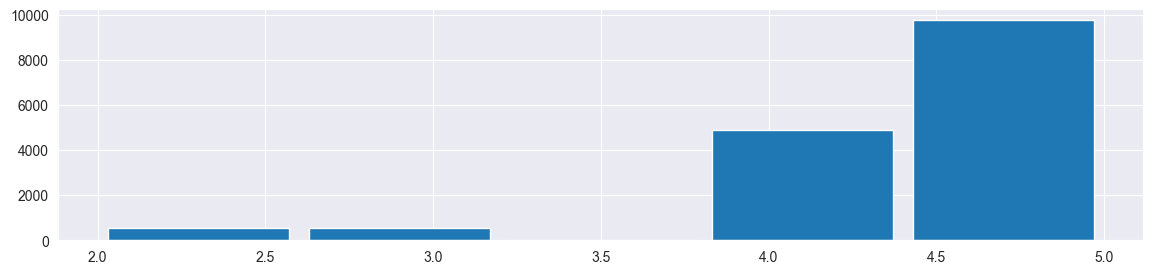

In [116]:
processed_df.doors_count.hist(bins=5, rwidth=0.9)

#### Количество мест

<Axes: >

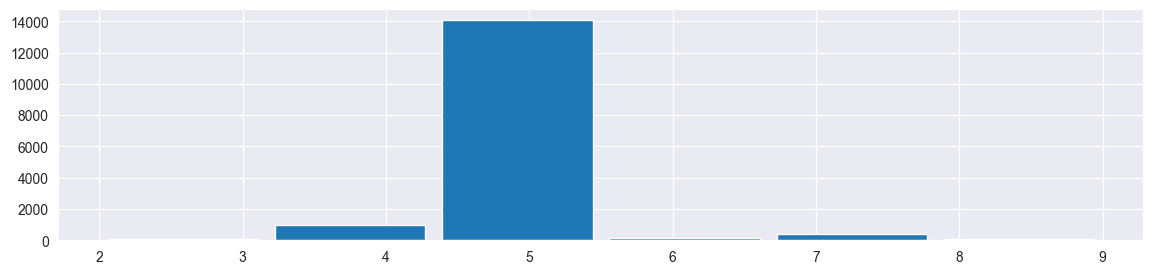

In [117]:
processed_df.seats_count.hist(bins=6, rwidth=0.9)

#### Длина

<Axes: >

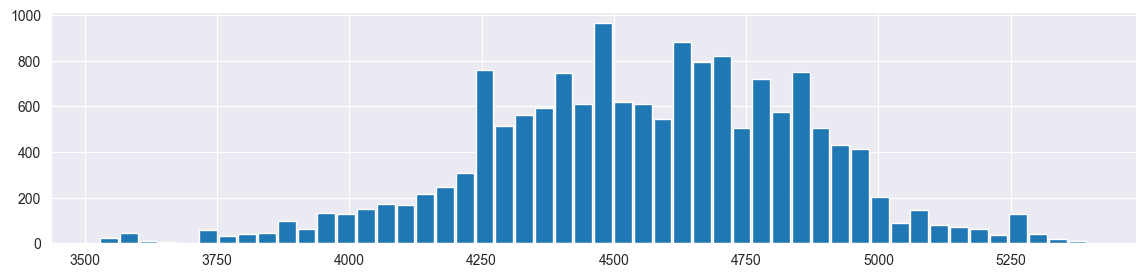

In [118]:
processed_df.length.hist(bins=50, rwidth=0.9)

#### Ширина

<Axes: >

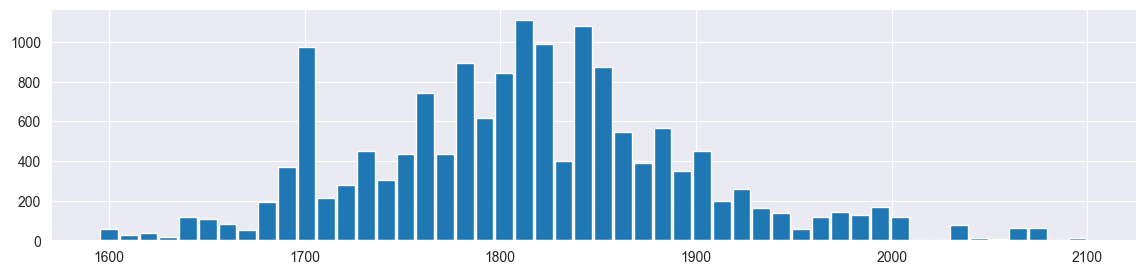

In [119]:
processed_df.width.hist(bins=50, rwidth=0.9)

#### Высота

<Axes: >

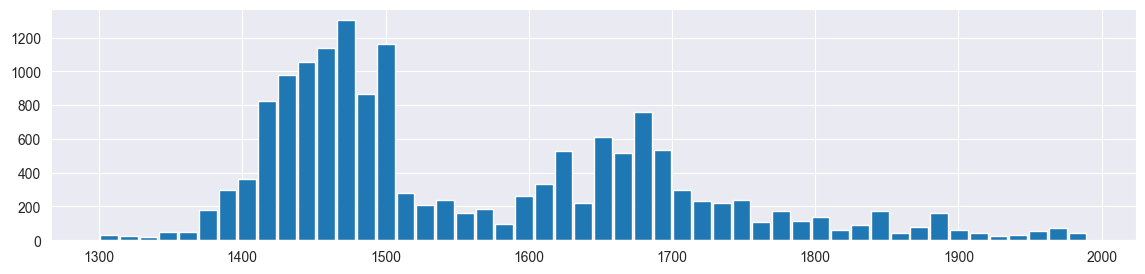

In [120]:
processed_df.height.hist(bins=50, rwidth=0.9)

#### Колёсная база

<Axes: >

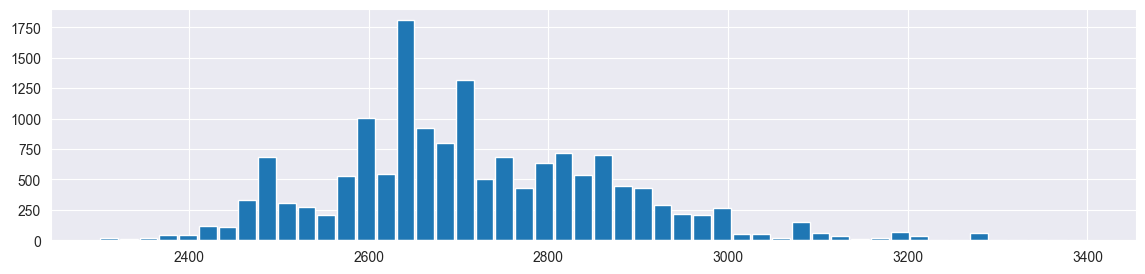

In [121]:
processed_df.wheelbase.hist(bins=50, rwidth=0.9)

#### Клиренс

<Axes: >

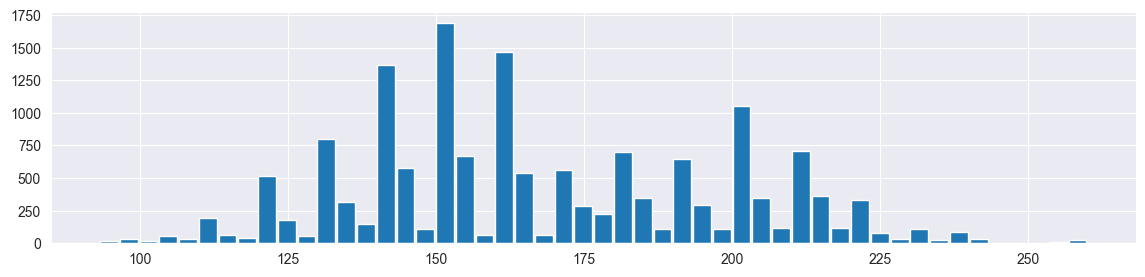

In [122]:
processed_df.clearance.hist(bins=50, rwidth=0.9)

#### Передняя колея

<Axes: >

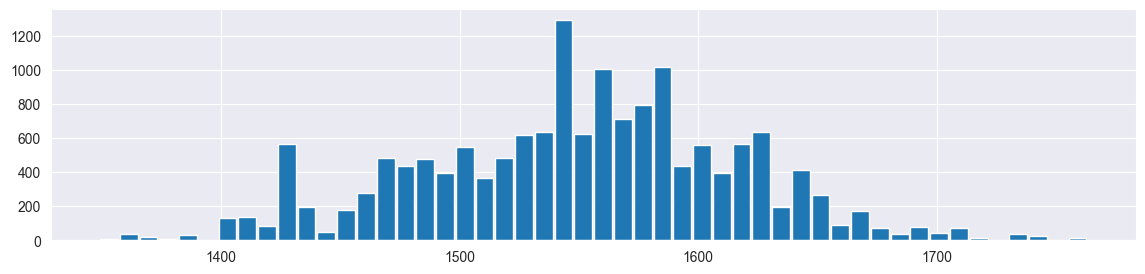

In [123]:
processed_df.front_track.hist(bins=50, rwidth=0.9)

#### Задняя колея

<Axes: >

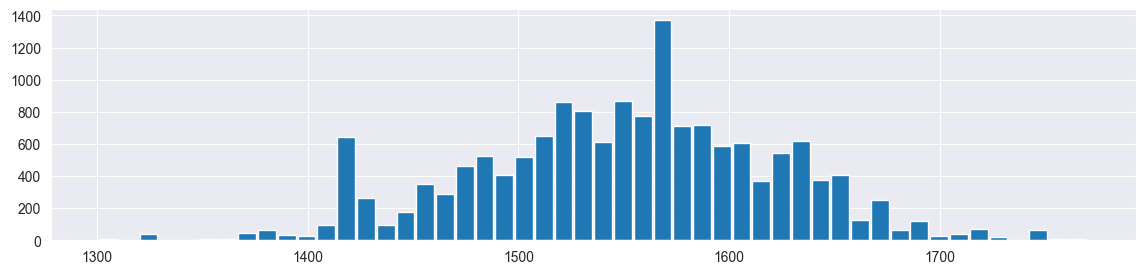

In [124]:
processed_df.rear_track.hist(bins=50, rwidth=0.9)

#### Максимальная скорость

<Axes: >

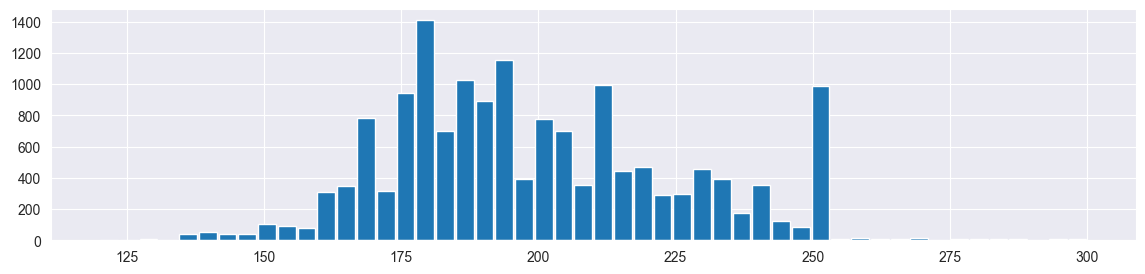

In [125]:
processed_df.max_speed.hist(bins=50, rwidth=0.9)

#### Разгон до 100

<Axes: >

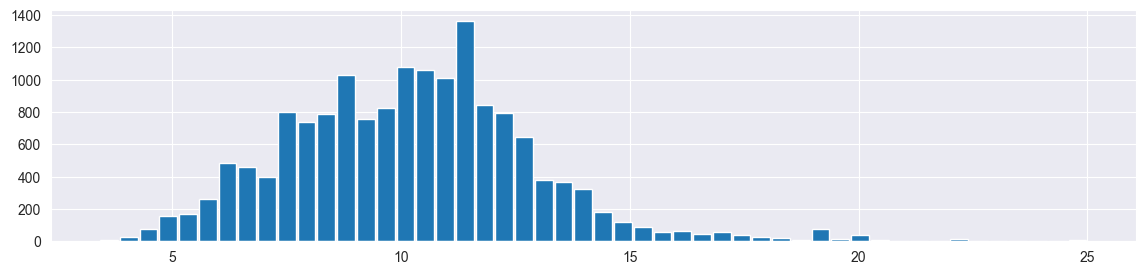

In [126]:
processed_df.zero_to_100.hist(bins=50, rwidth=0.9)

#### Смешанный расход топлива

<Axes: >

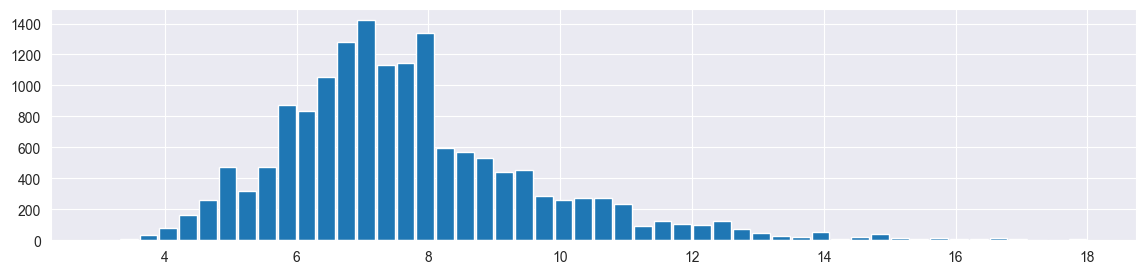

In [127]:
processed_df.fuel_consumption_mixed.hist(bins=50, rwidth=0.9)

#### Объём двигателя

<Axes: >

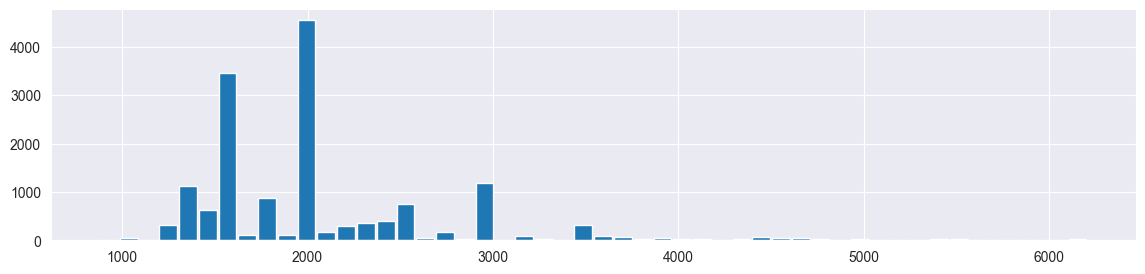

In [128]:
processed_df.engine_displacement.hist(bins=50, rwidth=0.9)

#### Мощность двигателя

<Axes: >

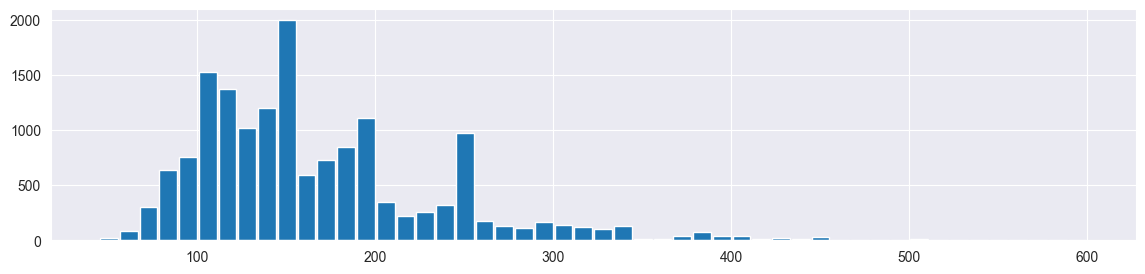

In [129]:
processed_df.engine_max_horsepower.hist(bins=50, rwidth=0.9)

#### Крутящий момент двигателя

<Axes: >

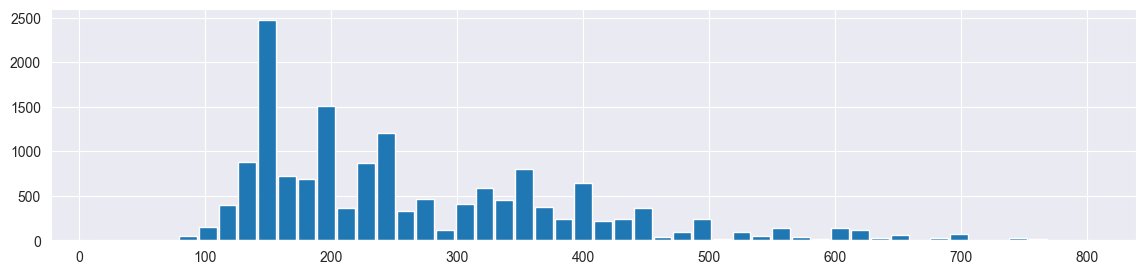

In [130]:
processed_df.engine_max_torque.hist(bins=50, rwidth=0.9)

#### Количество цилиндров в двигателе

<Axes: >

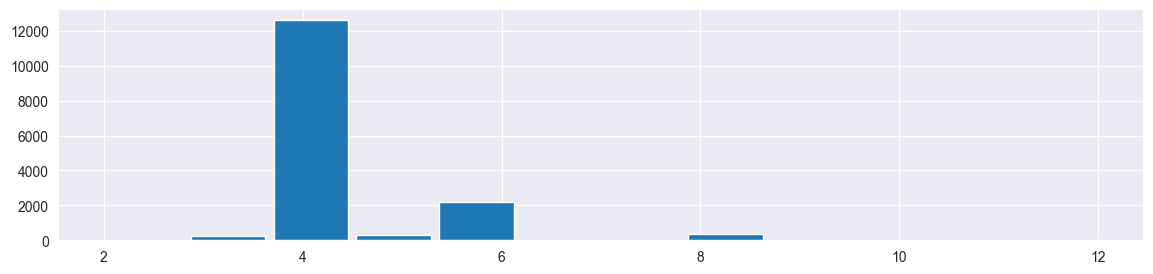

In [131]:
processed_df.engine_cylinders_count.hist(bins=12, rwidth=0.9)

#### Средняя цена

<Axes: >

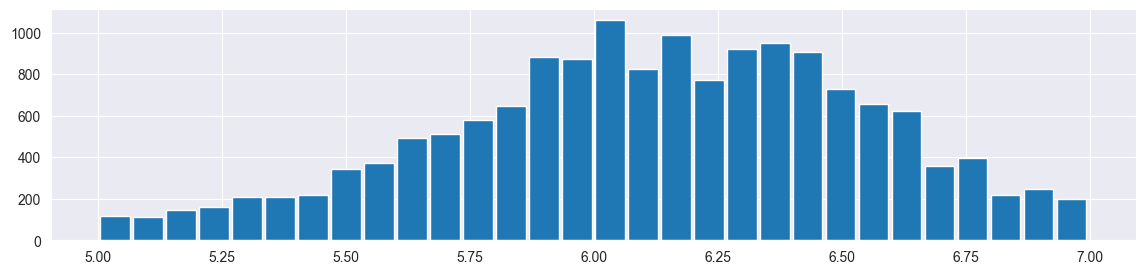

In [132]:
processed_df.price_avg.hist(bins=30, rwidth=0.9)

### Нормализация

In [133]:
non_normalized_df = processed_df
non_normalized_df

doors_count  seats_count  length  width  height  wheelbase  clearance  \
70               5            5    4394   1781    1722       2619        200   
71               5            5    4394   1781    1722       2619        200   
74               5            5    4394   1781    1722       2619        200   
117              4            6    4782   1904    1940       3098        164   
118              4            6    4782   1904    1940       3098        164   
...            ...          ...     ...    ...     ...        ...        ...   
58263            4            5    4630   1760    1480       2700        150   
58264            4            5    4630   1760    1480       2700        150   
58266            4            5    4630   1760    1480       2700        150   
58267            4            5    4630   1760    1480       2700        150   
58268            4            5    4630   1760    1480       2700        150   

       front_track  rear_track  max_speed  ...  body_type_Пикап  \
70            1554        1550        190  ...            False   
71            1554        1550        171  ...            False   
74            1554        1550        188  ...            False   
117           1615        1630        155  ...            False   
118           1615        1630        155  ...            False   
...            ...         ...        ...  ...              ...   
58263         1505        1510        220  ...            False   
58264         1505        1510        185  ...            False   
58266         1505        1510        205  ...            False   
58267         1505        1510        195  ...            False   
58268         1505        1510        200  ...            False   

       body_type_Родстер  body_type_Седан  body_type_Универсал  \
70                 False            False                False   
71                 False            False                False   
74                 False            False                False   
117                False            False                False   
118                False            False                False   
...                  ...              ...                  ...   
58263              False             True                False   
58264              False             True                False   
58266              False             True                False   
58267              False             True                False   
58268              False             True                False   

       body_type_Фургон  body_type_Хэтчбек  engine_type_ГБО  \
70                False              False            False   
71                False              False            False   
74                False              False            False   
117               False              False            False   
118               False              False            False   
...                 ...                ...              ...   
58263             False              False            False   
58264             False              False            False   
58266             False              False            False   
58267             False              False            False   
58268             False              False            False   

       engine_type_бензиновый  engine_type_гибридный  engine_type_дизельный  
70                       True                  False                  False  
71                       True                  False                  False  
74                       True                  False                  False  
117                     False                  False                   True  
118                     False                  False                   True  
...                       ...                    ...                    ...  
58263                    True                  False                  False  
58264                    True                  False               

In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

normalize_columns = processed_df.columns.to_numpy().tolist()
normalize_columns.remove('target')

scaler = ColumnTransformer([
        ('no_target', StandardScaler(), normalize_columns)
    ], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas').fit(processed_df)

processed_df = scaler.transform(processed_df)

### Коррелограмма

In [135]:
mc.MoveToLast(processed_df, 'target')

doors_count  seats_count    length     width    height  wheelbase  \
70        0.666161     0.002697 -0.547484 -0.384285  1.161687  -0.613074   
71        0.666161     0.002697 -0.547484 -0.384285  1.161687  -0.613074   
74        0.666161     0.002697 -0.547484 -0.384285  1.161687  -0.613074   
117      -0.713261     1.930451  0.743379  1.090704  2.731266   2.445421   
118      -0.713261     1.930451  0.743379  1.090704  2.731266   2.445421   
...            ...          ...       ...       ...       ...        ...   
58263    -0.713261     0.002697  0.237680 -0.636113 -0.580689  -0.095875   
58264    -0.713261     0.002697  0.237680 -0.636113 -0.580689  -0.095875   
58266    -0.713261     0.002697  0.237680 -0.636113 -0.580689  -0.095875   
58267    -0.713261     0.002697  0.237680 -0.636113 -0.580689  -0.095875   
58268    -0.713261     0.002697  0.237680 -0.636113 -0.580689  -0.095875   

       clearance  front_track  rear_track  max_speed  ...  body_type_Родстер  \
70      1.072127     0.063868   -0.000017  -0.347449  ...          -0.040693   
71      1.072127     0.063868   -0.000017  -1.077877  ...          -0.040693   
74      1.072127     0.063868   -0.000017  -0.424336  ...          -0.040693   
117    -0.100856     0.980352    1.119182  -1.692974  ...          -0.040693   
118    -0.100856     0.980352    1.119182  -1.692974  ...          -0.040693   
...          ...          ...         ...        ...  ...                ...   
58263  -0.557017    -0.672324   -0.559616   0.805858  ...          -0.040693   
58264  -0.557017    -0.672324   -0.559616  -0.539667  ...          -0.040693   
58266  -0.557017    -0.672324   -0.559616   0.229205  ...          -0.040693   
58267  -0.557017    -0.672324   -0.559616  -0.155231  ...          -0.040693   
58268  -0.557017    -0.672324   -0.559616   0.036987  ...          -0.040693   

       body_type_Седан  body_type_Универсал  body_type_Фургон  \
70           -0.649791            -0.312598         -0.049215   
71           -0.649791            -0.312598         -0.049215   
74           -0.649791            -0.312598         -0.049215   
117          -0.649791            -0.312598         -0.049215   
118          -0.649791            -0.312598         -0.049215   
...                ...                  ...               ...   
58263         1.538957            -0.312598         -0.049215   
58264         1.538957            -0.312598         -0.049215   
58266         1.538957            -0.312598         -0.049215   
58267         1.538957            -0.312598         -0.049215   
58268         1.538957            -0.312598         -0.049215   

       body_type_Хэтчбек  engine_type_ГБО  engine_type_бензиновый  \
70             -0.409655        -0.029849                0.517687   
71             -0.409655        -0.029849                0.517687   
74             -0.409655        -0.029849                0.517687   
117            -0.409655        -0.029849               -1.931670   
118            -0.409655        -0.029849               -1.931670   
...                  ...              ...                     ...   
58263          -0.409655        -0.029849                0.517687   
58264          -0.409655        -0.029849                0.517687   
58266          -0.409655        -0.029849                0.517687   
58267          -0.409655        -0.029849                0.517687   
58268          -0.409655        -0.029849                0.517687   

       engine_type_гибридный  engine_type_дизельный  target  
70                 -0.064422              -0.509877       1  
71                 -0.064422              -0.509877       1  
74                 -0.064422              -0.509877       1  
117                -0.064422               1.961258      -1  
118                -0.064422               1.961258      -1  
...                      ...                    ...     ...  
58263              -0.064422              -0.509877      -1  
58264              -0.06442

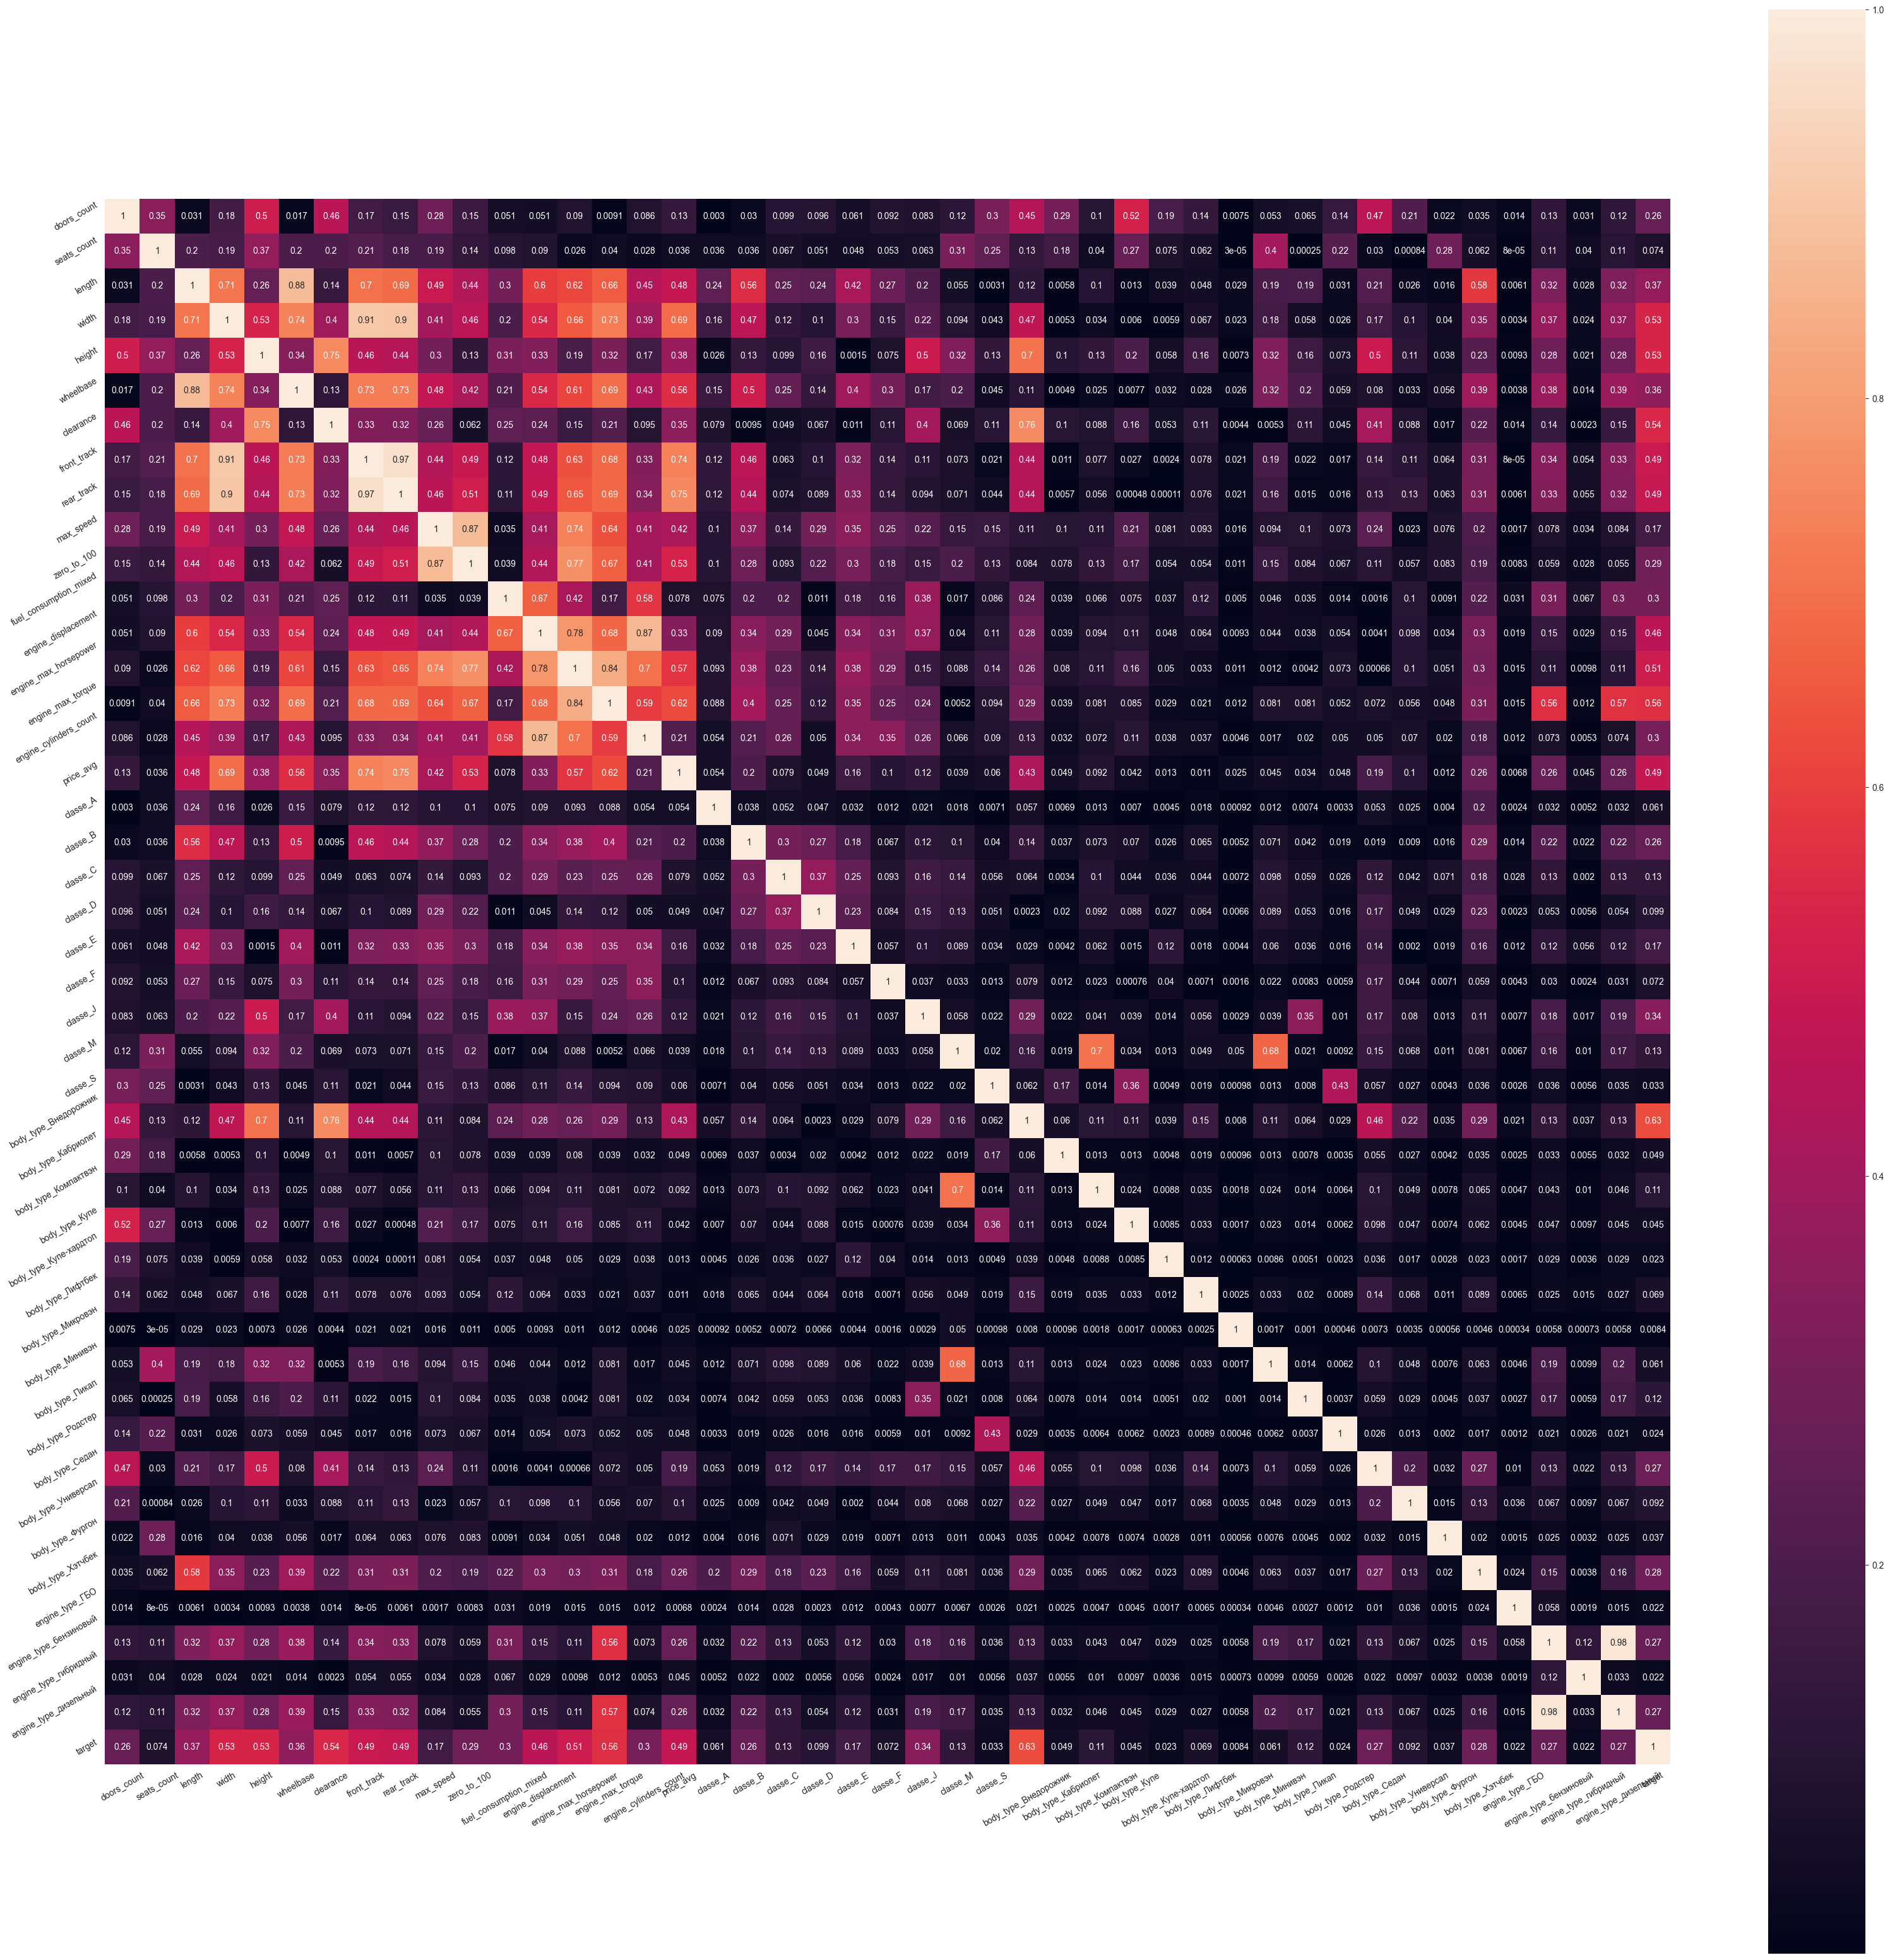

In [136]:
plt.figure(figsize=(40, 40))
sns.heatmap(processed_df.corr().abs(), square=True, linecolor='white', annot=True)
plt.yticks(rotation=30)
plt.xticks(rotation=30)
plt.show()

Штош, смотрим на последнюю строку и видим, что половину фич можно выкинуть к чертям.

Итак, имеет смысл оставить только:
doors_count, width, height, clearance, front_track, rear_track, engine_max_horsepower, engine_max_torque, price_avg, classe_J, body_type_Внедорожник, body_type_Седан

In [137]:
# processed_df = processed_df[["length", "width", "height", "wheelbase", "clearance", "front_track", "rear_track", "max_speed", "zero_to_100", "engine_displacement", "engine_max_horsepower", "engine_max_torque", "engine_cylinders_count", "drive_type_передний", "drive_type_полный", "engine_type_бензиновый", "engine_type_дизельный", "classe_B", "classe_C", "classe_E", "classe_F", "classe_J", "target"]]
# processed_df = processed_df[["length", "width", "height", "wheelbase", "front_track", "rear_track", "max_speed", "zero_to_100", "engine_displacement", "engine_max_horsepower", "engine_max_torque", "engine_cylinders_count", "drive_type_передний", "drive_type_полный", "target"]]
# processed_df = processed_df[["doors_count", "width", "height", "clearance", "front_track", "rear_track", "engine_max_horsepower", "engine_max_torque", "price_avg", "classe_J", "body_type_Внедорожник", "body_type_Седан", "target"]]
processed_df = processed_df[["length", "width", "height", "wheelbase", "clearance", "front_track", "rear_track", "fuel_consumption_mixed", "engine_displacement", "engine_max_horsepower", "engine_max_torque", "engine_cylinders_count", "price_avg", "classe_J", "body_type_Внедорожник", "target"]]

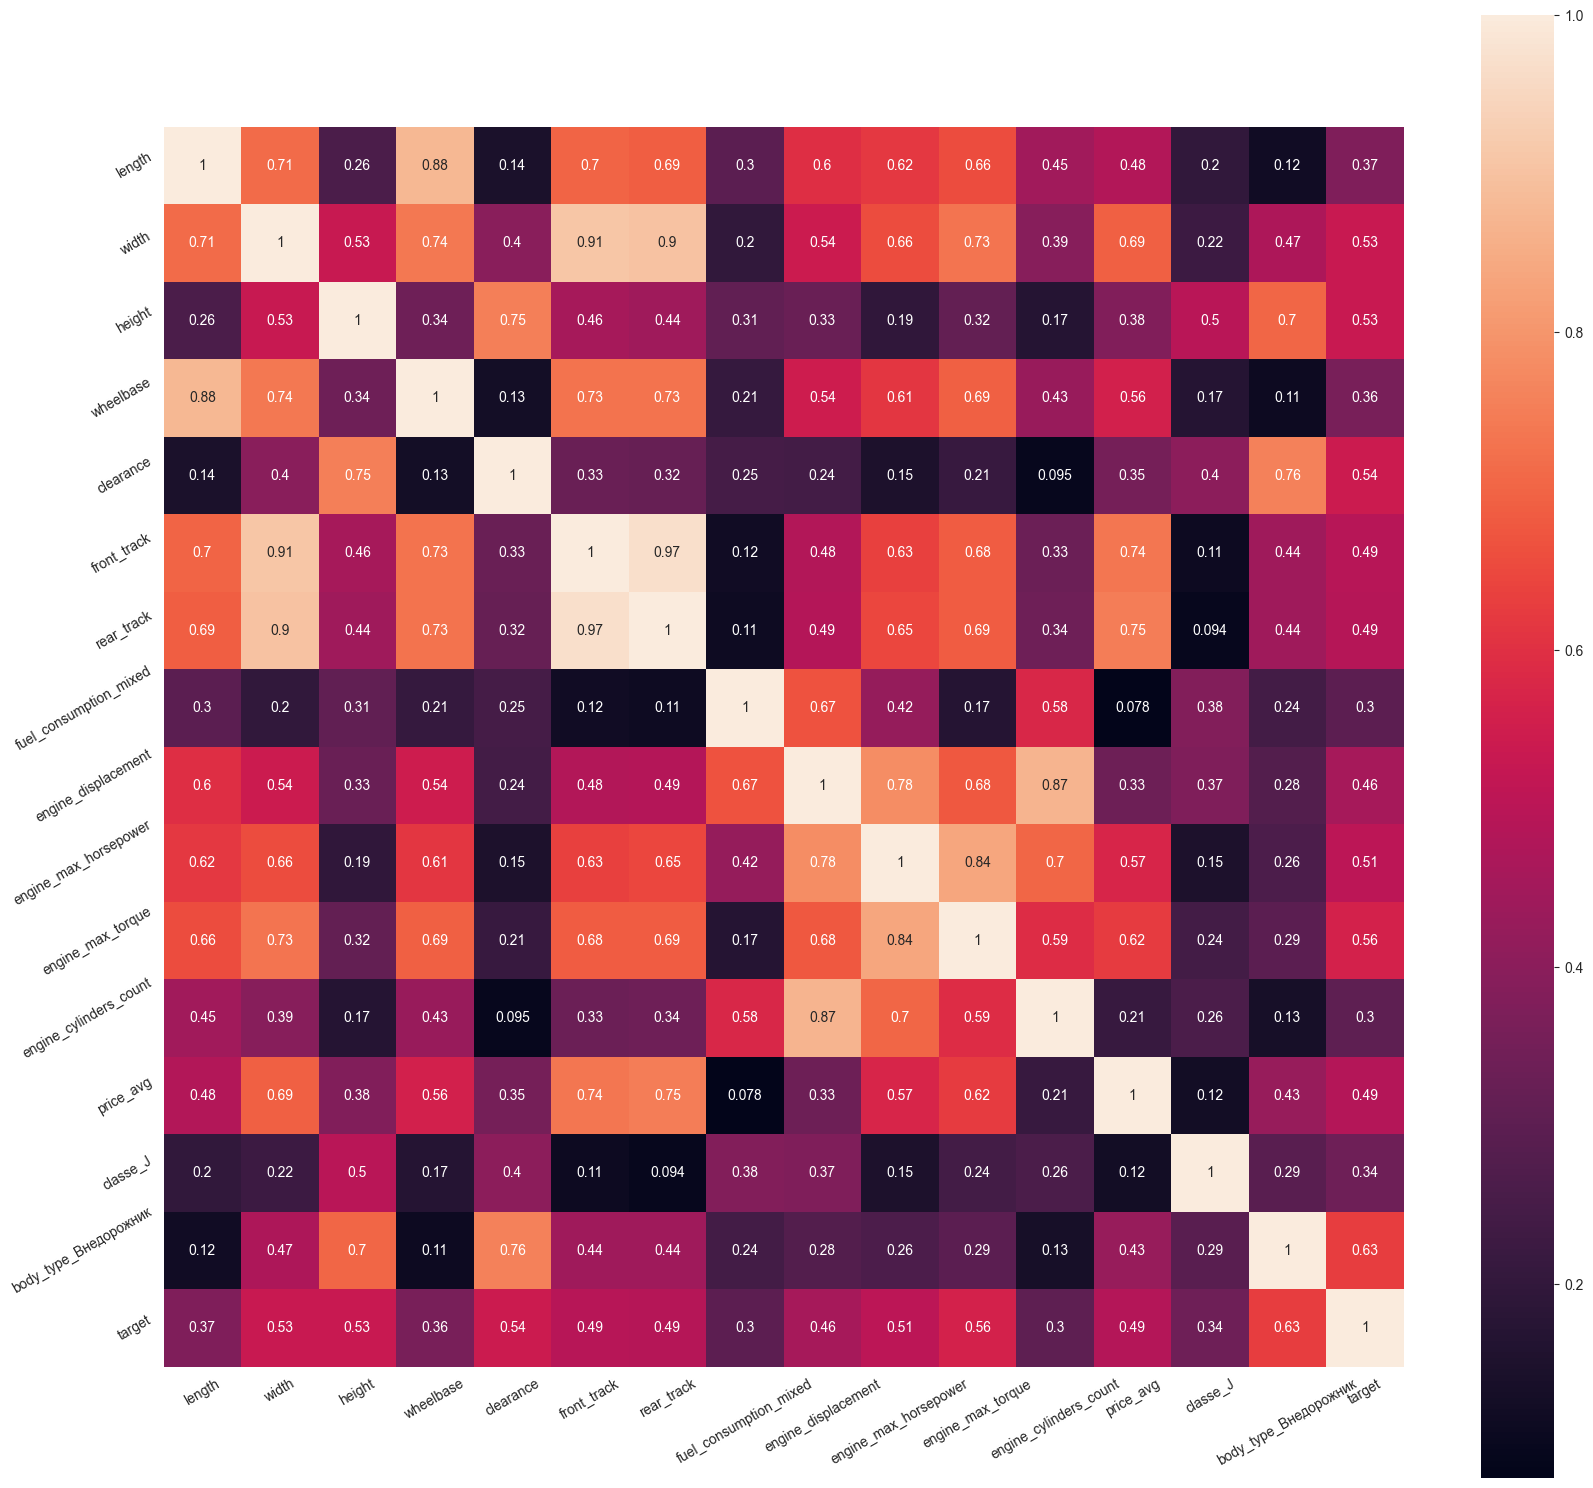

In [138]:
plt.figure(figsize=(20, 19))
sns.heatmap(processed_df.corr().abs(), square=True, linecolor='white', annot=True)
plt.yticks(rotation=30)
plt.xticks(rotation=30)
plt.show()

## Разбиение на train, valid, test

In [139]:
x = processed_df.drop('target', axis=1)
y = processed_df['target']
train_features, test_features, train_target, test_target = train_test_split(x, y, test_size=0.66, random_state=0)
test_features, val_features, test_target, val_target = train_test_split(test_features, test_target, test_size=0.5, random_state=0)

print(train_features.shape)
print(train_target.shape)

print(val_features.shape)
print(val_target.shape)

print(test_features.shape)
print(test_target.shape)

(5347, 15)
(5347,)
(5190, 15)
(5190,)
(5190, 15)
(5190,)


## Выбор функции качества

По опыту прошлого семестра чувствую, что здесь с кайфом зайдёт roc_auc

In [140]:
from sklearn.metrics import roc_auc_score, classification_report

In [141]:
def stat_visualize(predictions, test):
    predictions = pd.Series(predictions)
    fig, ax = plt.subplots()
    ax.hist(test, bins=3, fc=(0, 1, 0, 1.0))
    ax.hist(predictions, bins=3, fc=(0, 0, 1, 0.5))

In [142]:
def plot_roc_auc(models, param_label="Parameter"):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    pred_train = []
    pred_test = []
    for pos, model in enumerate(models):
        pred_train.append(roc_auc_score(train_target.to_numpy(), model.predict(train_features.to_numpy())))
        pred_test.append(roc_auc_score(test_target.to_numpy(), model.predict(test_features.to_numpy())))
    ax1.plot(pred_train, marker=".")
    ax2.plot(pred_test, marker=".")
    for i in [ax1, ax2]:
        i.grid()    
        i.ticklabel_format(useOffset=False, style='plain')
        i.set_xlabel(param_label, fontsize=20)
    ax1.set_ylabel("ROC AUC (train)", fontsize=20)
    ax2.set_ylabel("ROC AUC (test)", fontsize=20)
    fig.tight_layout()

# Линейная регрессия

In [143]:
def m_funcs(X, Y):
    funcs = []

    for i in range(len(X)):
        funcs.append(
            lambda W, i=i: (
                sum(
                    W * X[i]
                )
                * Y[i]  # Работает только для бинарной классификации
            )
        )

    return funcs

In [144]:
def loss_hebb(m):
    return [(lambda W, m_i=m_i: max(0, -m_i(W))) for m_i in m]

In [145]:
def loss_svm(m):
    return [(lambda W, m_i=m_i: max(0, 1-m_i(W))) for m_i in m]

In [146]:
def loss_lr(m):
    return [(lambda W, m_i=m_i: np.log2(1 + np.exp(-m_i(W)))) for m_i in m]

In [147]:
def loss_lda(m):
    return [(lambda W, m_i=m_i: np.square(1 - m_i(W))) for m_i in m]

In [148]:
def loss_ann(m):
    return [(lambda W, m_i=m_i: 2/(1 + np.exp(m_i(W)))) for m_i in m]

In [149]:
def loss_adaboost(m):
    return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]

# Stochastic Gradient Descent

## Библиотечный sgd классификатор

In [150]:
from sklearn.linear_model import SGDClassifier

models = {}

def objective(trial: optuna.Trial):
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    learning_rate = trial.suggest_categorical('learning_rate', ['optimal', 'constant', 'invscaling', 'adaptive'])
    alpha = trial.suggest_float('alpha', 0.0, 10.)
    eta0 = trial.suggest_float('eta0', 0.0, 10.)
    power_t = trial.suggest_float('power_t', -10., 10.)
    model = SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=alpha, learning_rate=learning_rate, eta0=eta0, power_t=power_t, class_weight=class_weight).fit(train_features.to_numpy(), train_target.to_numpy())
    models[trial.number] = model
    y_pred = model.predict(val_features.to_numpy())
    score = roc_auc_score(val_target, y_pred, average='weighted')
    return 1. - score

study = optuna.create_study()
study.optimize(objective, 
               timeout=60,
               # n_jobs=-1,
               )

best_model = models[study.best_trial.number]
study.best_params

[I 2024-05-21 03:38:41,723] A new study created in memory with name: no-name-3f0da083-f47e-42b6-b5bc-7fa189e573de
[I 2024-05-21 03:38:41,735] Trial 0 finished with value: 0.5 and parameters: {'class_weight': 'balanced', 'learning_rate': 'invscaling', 'alpha': 5.142148394322451, 'eta0': 1.2577024144959281, 'power_t': -2.677676465151288}. Best is trial 0 with value: 0.5.
[I 2024-05-21 03:38:41,744] Trial 1 finished with value: 0.5 and parameters: {'class_weight': None, 'learning_rate': 'constant', 'alpha': 9.313426298056378, 'eta0': 0.008831141549906496, 'power_t': -3.259272400709154}. Best is trial 0 with value: 0.5.
[I 2024-05-21 03:38:41,755] Trial 2 finished with value: 0.5 and parameters: {'class_weight': None, 'learning_rate': 'optimal', 'alpha': 9.200779356670648, 'eta0': 1.8827113897314207, 'power_t': 7.21863950020505}. Best is trial 0 with value: 0.5.
[I 2024-05-21 03:38:41,765] Trial 3 finished with value: 0.5 and parameters: {'class_weight': 'balanced', 'learning_rate': 'optim

{'class_weight': 'balanced',
 'learning_rate': 'optimal',
 'alpha': 0.0021597603679755785,
 'eta0': 9.322378891790507,
 'power_t': -0.5607711643330977}

              precision    recall  f1-score   support

          -1       0.94      0.87      0.90      3364
           1       0.79      0.90      0.84      1826

    accuracy                           0.88      5190
   macro avg       0.86      0.88      0.87      5190
weighted avg       0.89      0.88      0.88      5190


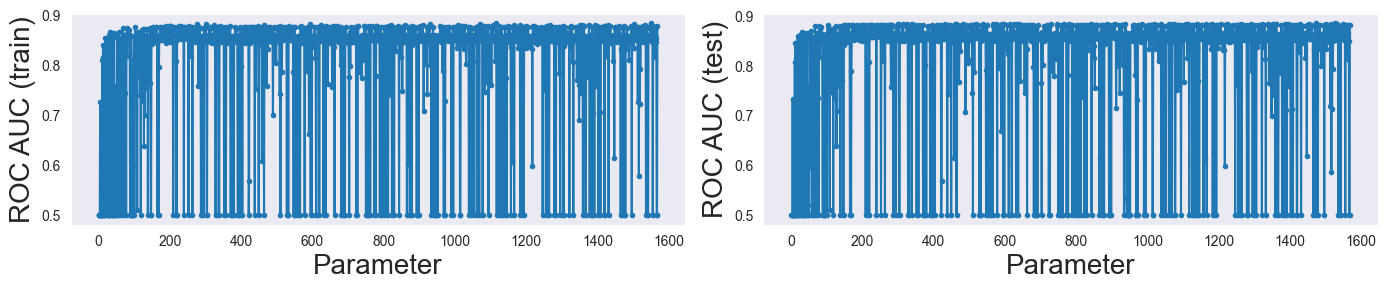

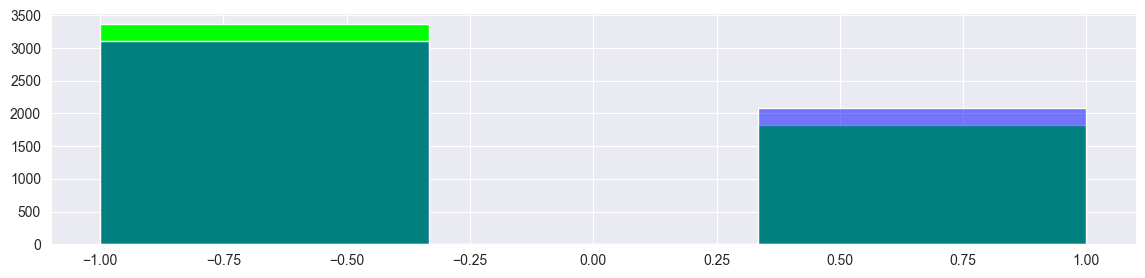

In [151]:
plot_roc_auc(list(models.values()))
print(classification_report(test_target, best_model.predict(test_features.to_numpy())))
stat_visualize(best_model.predict(test_features.to_numpy()), test_target)

In [152]:
best_model.coef_.T

array([[ 0.47882436],
       [-0.53464648],
       [ 0.0307845 ],
       [-0.28772244],
       [ 0.63761133],
       [ 0.24165675],
       [-0.09929516],
       [ 0.68537134],
       [ 0.        ],
       [ 0.48077127],
       [ 1.63460491],
       [-0.49395321],
       [ 0.61621465],
       [ 0.66853495],
       [ 0.89736075]])

## Самодельный sgd классификатор

### Алгоритм выбора learning rate

In [153]:
def constant_lr_decay(lr):
    def f(*_, **__):
        return lr

    return f


def exp_decay(lr0, k):
    def f(epoch):
        return lr0 * math.exp(-k * epoch)

    return f


def step_decay(lr0, drop, epochs_drop):
    def f(epoch):
        return lr0 * (drop ** (epoch // epochs_drop))

    return f

### Численный градиент

In [154]:
def numeric_gradient(f, x, h=1e-6):
    """
    Функция для численного вычисления градиента функции f в точке x.
    Параметры:
        x: точка, в которой нужно вычислить градиент
        h: малое число для вычисления приближенного значения производной
    """
    if np.isnan(x).any():
        raise OverflowError("NaN in x")
    n = x.shape[0]  # число переменных
    grad = np.zeros(n)  # инициализация градиента
    for i in range(n):
        x_plus = x.copy()
        x_plus[i] += h  # прибавляем малое число к i-ой координате
        x_minus = x.copy()
        x_minus[i] -= h  # вычитаем малое число из i-ой координаты
        f_plus = f(x_plus)
        f_minus = f(x_minus)
        if np.isnan(f_plus).any() or np.isnan(f_plus).any():
            raise OverflowError("NaN in x")
        grad[i] = (f_plus - f_minus) / (
                2 * h
        )  # вычисляем приближенное значение производной
    return grad

### Визуализация спуска

In [155]:
def visualize_descent(points, f, print_points=False):
    """
    Функция для визуализации работы градиентного спуска на функции f. Первым
    графиком выводится ломаная пар точек (iter, f(x)), получающихся в процессе работы метода,
    а также, опционально, печатаются координаты этих точек.
    Параметры:
        points: шаги градиентного спуска
    """
    points = np.array(points)
    fig, ax1 = plt.subplots()
    if print_points:
        print(points[:10])
        print("...")
        print(points[-10:])
    ax1.plot(f(points.T))
    # ax1.set_yscale("symlog")
    ax1.grid()
    ax1.set_xlabel("# of iter", fontsize=20)
    ax1.set_ylabel("f(X)", fontsize=20)

### Регуляризация

In [156]:
def lasso(lambd):
  return lambda W: lambd * sum(np.abs(W))

def tihonov(lambd):
  return lambda W: lambd * sum(np.power(W, 2))

def elastic(lambd1, lambd2):
  return lambda W: lasso(lambd1)(W) + tihonov(lambd2)(W)

### Minibatch

In [157]:
import typing as ty


def minibatch_descent(
        f: ty.List[ty.Callable],
        df,
        x0,
        lr,
        tol,
        n_epochs,
        reg_part=lambda W: 0,
        batch_size=None,
        silent=False,
        global_stats=False,
):
    if batch_size is None:
        batch_size = len(f)
    random.shuffle(f)
    n = len(f)
    points = [x0]

    last_grads = np.array([0.0 for _ in range(len(x0))])
    num_grads = 0
    last_epoch = 0

    for i in range(n // batch_size * n_epochs):
        if i * batch_size // n > last_epoch:
            if np.linalg.norm(last_grads / num_grads) < tol:
                if not silent:
                    print(np.linalg.norm(last_grads / num_grads))
                break
            last_grads = 0.0
            num_grads = 0
            last_epoch = i * batch_size // n

        x = points[-1]
        part_grad = np.array(
            df(lambda *args: (sum([f[(i * batch_size + j) % n](*args) for j in range(batch_size)]) + reg_part(*args)), x)
            / batch_size,
        )

        last_grads += part_grad
        num_grads += 1

        points.append(x - lr(i * batch_size // n) * part_grad)

    if global_stats:
        global _stats
        _stats.append(len(points))
    return points

### Nesterov

In [158]:
def nesterov_minibatch_descent(
        f: ty.List[ty.Callable],
        df,
        x0,
        lr,
        tol,
        n_epochs,
        reg_part=lambda W: 0,
        batch_size=None,
        alpha=0.9,
        silent=False,
        global_stats=False,
):
    if batch_size is None:
        batch_size = len(f)
    random.shuffle(f)
    n = len(f)
    points = [x0]

    last_grads = np.array([0.0 for _ in range(len(x0))])
    num_grads = 0
    last_epoch = 0

    grad_steps = [np.array([0.0] * len(x0))]

    for i in range(n // batch_size * n_epochs):
        if i * batch_size // n > last_epoch:
            if np.linalg.norm(last_grads / num_grads) < tol:
                if not silent:
                    print(np.linalg.norm(last_grads / num_grads))
                break
            last_grads = 0.0
            num_grads = 0
            last_epoch = i * batch_size // n

        lri = lr(i * batch_size // n)
        approx_next_point = points[-1] - lri * alpha * grad_steps[-1]
        part_grad = np.array(
            df(lambda *args: (sum([f[(i * batch_size + j) % n](*args) for j in range(batch_size)]) + reg_part(*args)), approx_next_point)
            / batch_size,
        )

        last_grads += part_grad
        num_grads += 1

        grad_steps.append(alpha * grad_steps[-1] + (1 - alpha) * part_grad)
        points.append(points[-1] - lri * grad_steps[-1])

    if global_stats:
        global _stats
        _stats.append(len(points))
    return points

### Minibatch with momentum

In [159]:
def momentum_minibatch_descent(
        f: ty.List[ty.Callable],
        df,
        x0,
        lr,
        tol,
        n_epochs,
        reg_part=lambda W: 0,
        batch_size=None,
        alpha=0.9,
        silent=False,
        global_stats=False,
):
    if batch_size is None:
        batch_size = len(f)
    random.shuffle(f)
    n = len(f)
    points = [x0]

    last_grads = np.array([0.0 for _ in range(len(x0))])
    num_grads = 0
    last_epoch = 0

    grad_steps = [np.array([0] * len(x0))]
    for i in range(n // batch_size * n_epochs):
        if i * batch_size // n > last_epoch:
            if np.linalg.norm(last_grads / num_grads) < tol:
                if not silent:
                    print(np.linalg.norm(last_grads / num_grads))
                break
            last_grads = 0.0
            num_grads = 0
            last_epoch = i * batch_size // n

        part_grad = np.array(
            df(lambda *args: (sum([f[(i * batch_size + j) % n](*args) for j in range(batch_size)]) + reg_part(*args)), points[-1])
            / batch_size,
        )

        last_grads += part_grad
        num_grads += 1

        grad_steps.append(alpha * grad_steps[-1] + (1 - alpha) * part_grad)
        points.append(points[-1] - lr(i * batch_size // n) * grad_steps[-1])
    if global_stats:
        global _stats
        _stats.append(len(points))
    return points

### Adagrad

In [160]:
def adagrad_minibatch_descent(
        f: ty.List[ty.Callable],
        df,
        x0,
        lr,
        tol,
        n_epochs,
        reg_part=lambda W: 0,
        batch_size=None,
        silent=False,
        global_stats=False,
):
    if batch_size is None:
        batch_size = len(f)
    random.shuffle(f)
    n = len(f)
    points = [x0]
    grad_sums = np.zeros((len(x0)))
    eps = 1e-8  # сглаживающий параметр, чтобы избежать деления на 0

    last_grads = np.array([0.0 for _ in range(len(x0))])
    num_grads = 0
    last_epoch = 0

    for i in range(n // batch_size * n_epochs):
        if i * batch_size // n > last_epoch:
            if np.linalg.norm(last_grads / num_grads) < tol:
                if not silent:
                    print(np.linalg.norm(last_grads / num_grads))
                break
            last_grads = 0.0
            num_grads = 0
            last_epoch = i * batch_size // n

        x = points[-1]
        part_grad = np.array(
            df(lambda *args: (sum([f[(i * batch_size + j) % n](*args) for j in range(batch_size)]) + reg_part(*args)), x)
            / batch_size,
        )

        grad_sums += part_grad ** 2

        last_grads += part_grad
        num_grads += 1

        points.append(
            x - lr(i * batch_size // n) * (part_grad * (grad_sums + eps) ** (-1 / 2))
        )

    if global_stats:
        global _stats
        _stats.append(len(points))
    return points

### RMSProp

In [161]:
def rmsprop_minibatch_descent(
        f: ty.List[ty.Callable],
        df,
        x0,
        lr,
        tol,
        n_epochs,
        reg_part=lambda W: 0,
        batch_size=None,
        alpha=0.9,
        silent=False,
        global_stats=False,
):
    if batch_size is None:
        batch_size = len(f)
    random.shuffle(f)
    n = len(f)
    points = [x0]
    grad_steps = [np.array([0] * len(x0))]
    eps = 1e-8

    last_grads = np.array([0.0 for _ in range(len(x0))])
    num_grads = 0
    last_epoch = 0

    for i in range(n // batch_size * n_epochs):
        if i * batch_size // n > last_epoch:
            if np.linalg.norm(last_grads / num_grads) < tol:
                if not silent:
                    print(np.linalg.norm(last_grads / num_grads))
                break
            last_grads = 0.0
            num_grads = 0
            last_epoch = i * batch_size // n

        x = points[-1]
        part_grad = np.array(
            df(lambda *args: (sum([f[(i * batch_size + j) % n](*args) for j in range(batch_size)]) + reg_part(*args)), x)
            / batch_size,
        )

        last_grads += part_grad
        num_grads += 1

        grad_steps.append(grad_steps[-1] * alpha + part_grad ** 2 * (1 - alpha))
        points.append(
            x
            - lr(i * batch_size // n)
            * (part_grad * ((grad_steps[-1] + eps) ** (-1 / 2)))
        )

    if global_stats:
        global _stats
        _stats.append(len(points))
    return points

### Adam

In [162]:
def adam_minibatch_descent(
        f: ty.List[ty.Callable],
        df,
        x0,
        lr,
        tol,
        n_epochs,
        reg_part=lambda W: 0,
        batch_size=None,
        betta1=0.9,
        betta2=0.9,
        silent=False,
        global_stats=False,
):
    if batch_size is None:
        batch_size = len(f)
    random.shuffle(f)
    n = len(f)
    points = [x0]
    grad_square_steps = [np.array([0] * len(x0))]
    grad_steps = [np.array([0] * len(x0))]
    eps = 1e-8

    last_grads = np.array([0.0 for _ in range(len(x0))])
    num_grads = 0
    last_epoch = 0

    for i in range(n // batch_size * n_epochs):
        if i * batch_size // n > last_epoch:
            if np.linalg.norm(last_grads / num_grads) < tol:
                if not silent:
                    print(np.linalg.norm(last_grads / num_grads))
                break
            last_grads = 0.0
            num_grads = 0
            last_epoch = i * batch_size // n

        x = points[-1]
        part_grad = np.array(
            df(lambda *args: (sum([f[(i * batch_size + j) % n](*args) for j in range(batch_size)]) + reg_part(*args)), x)
            / batch_size,
        )

        last_grads += part_grad
        num_grads += 1

        grad_square_steps.append(
            grad_square_steps[-1] * betta1 + part_grad ** 2 * (1 - betta1)
        )
        grad_steps.append(grad_steps[-1] * betta2 + part_grad * (1 - betta2))
        grad_step_normalized = grad_steps[-1] / (1 - betta1 ** (i + 1))
        grad_square_step_normalized = grad_square_steps[-1] / (1 - betta2 ** (i + 1))
        points.append(
            x
            - lr(i * batch_size // n)
            * grad_step_normalized
            * (grad_square_step_normalized + eps) ** (-1 / 2)
        )

    if global_stats:
        global _stats
        _stats.append(len(points))
    return points

### Классификатор

In [163]:
class DIYSGDClassifier:
    def __init__(self, loss=loss_adaboost, penalty=lambda W: 0, learning_rate=constant_lr_decay(0.1), tol=1e-3, n_epochs=1000, solver=minibatch_descent):
        self.emp_risk = None
        self.theta_not_weights = None
        self.loss = loss
        self.penalty = penalty
        self.learning_rate = learning_rate
        self.tol = tol
        self.n_epochs = n_epochs
    
    def fit(self, X, Y):
        self.emp_risk = self.loss(m_funcs(X, Y))
        
        self.theta_not_weights = minibatch_descent(
            f=self.emp_risk,
            df=numeric_gradient,
            x0=np.zeros(X.shape[1]),
            lr=self.learning_rate,
            tol=self.tol,
            n_epochs=self.n_epochs,
            reg_part=self.penalty,
            batch_size=None,  # Full batch
        )
        return self
        
    def predict(self, X):
        return 2 * ((np.dot(X, self.theta_not_weights[-1])) >= 0) - 1
    
    def visualize(self, test_X=None, test_Y=None):
        visualize_descent(self.theta_not_weights, lambda W: [sum([j(i) for j in self.emp_risk]) for i in W.T])
        if test_X is not None and test_Y is not None:
            visualize_descent(self.theta_not_weights, lambda W: [sum([j(i) for j in self.loss(m_funcs(test_X, test_Y))]) for i in W.T])


### Демо

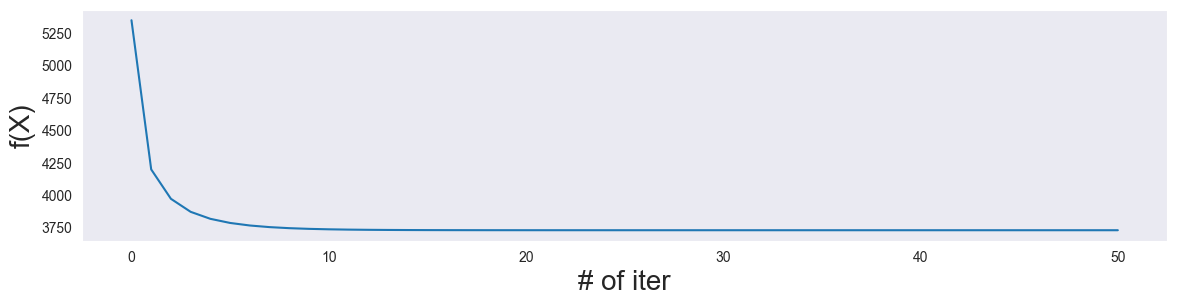

In [164]:
model = DIYSGDClassifier(n_epochs=50, penalty=elastic(0.15 * 0.0001, (1. - 0.15) * 0.0001), learning_rate=exp_decay(0.1, 0.4)).fit(train_features.to_numpy(), train_target.to_numpy())
model.predict(val_features.to_numpy())
model.visualize()

In [165]:
from sklearn.linear_model import SGDClassifier
models = {}

def objective(trial: optuna.Trial):    
    elastic_lambda1 = trial.suggest_float('lambda1', 0.0, 10.)
    elastic_lambda2 = trial.suggest_float('lambda2', 0.0, 100.)
    
    learning_rate = trial.suggest_categorical('learning_rate', ['const', 'exp', 'step'])
    if learning_rate == 'const':
        learning_rate = constant_lr_decay(trial.suggest_float('lr0', 0.0, 1.))
    elif learning_rate == 'exp':
        learning_rate = exp_decay(trial.suggest_float('lr0', 0.0, 1.), trial.suggest_float('k', 0.0, 1.))
    else:
        learning_rate = step_decay(trial.suggest_float('lr0', 0.0, 1.), trial.suggest_float('lr_drop_amount', 0.0, 1.), trial.suggest_int('lr_drop_epochs', 1, 10))
    
    loss = trial.suggest_categorical('loss', ['hebb', 'svm', 'lr', 'lda', 'ann', 'adaboost'])
    if loss == 'hebb':
        loss = loss_hebb
    elif loss == 'svm':
        loss = loss_svm
    elif loss == 'lr':
        loss = loss_lr
    elif loss == 'lda':
        loss = loss_lda
    elif loss == 'ann':
        loss = loss_ann
    else:
        loss = loss_adaboost
    
    solver = trial.suggest_categorical('solver', ['adam', 'rmsprop', 'adagrad', 'momentum', 'nesterov', 'minibatch'])
    if solver == 'adam':
        solver = adam_minibatch_descent
    elif solver == 'rmsprop':
        solver = rmsprop_minibatch_descent
    elif solver == 'adagrad':
        solver = adagrad_minibatch_descent
    elif solver == 'momentum':
        solver = momentum_minibatch_descent
    elif solver == 'nesterov':
        solver = nesterov_minibatch_descent
    elif solver == 'minibatch':
        solver = minibatch_descent
    else:
        raise AssertionError()
    
    try:
        model = DIYSGDClassifier(n_epochs=50, penalty=elastic(elastic_lambda1, elastic_lambda2), learning_rate=learning_rate, loss=loss, solver=solver).fit(train_features.to_numpy(), train_target.to_numpy())
        models[trial.number] = model
        y_pred = model.predict(val_features.to_numpy())
        score = roc_auc_score(val_target, y_pred, average='weighted')
        return 1. - score
    except OverflowError:
        print("Overflow in trial", trial.number)
        return 1.

study = optuna.create_study()
study.optimize(objective, 
               timeout=4*60*60,
               n_jobs=20,
               )

best_model = models[study.best_trial.number]
study.best_params

[I 2024-05-21 03:40:12,966] A new study created in memory with name: no-name-725e6923-b9e6-4c38-9300-19d883c2f896
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\3912452865.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f_plus - f_minus) / (
[I 2024-05-21 03:40:48,772] Trial 7 finished with value: 1.0 and parameters: {'lambda1': 5.6316216740993905, 'lambda2': 53.21861082368229, 'learning_rate': 'const', 'lr0': 0.912555649199913, 'loss': 'adaboost', 'solver': 'nesterov'}. Best is trial 7 with value: 1.0.


Overflow in trial 7
Overflow in trial 8


[I 2024-05-21 03:40:48,961] Trial 8 finished with value: 1.0 and parameters: {'lambda1': 9.622687769070922, 'lambda2': 42.14825447059886, 'learning_rate': 'exp', 'lr0': 0.9552055760602521, 'k': 0.20275279403841173, 'loss': 'adaboost', 'solver': 'momentum'}. Best is trial 7 with value: 1.0.


0.0


[I 2024-05-21 03:42:20,504] Trial 18 finished with value: 0.27595951629863313 and parameters: {'lambda1': 3.423060530511096, 'lambda2': 16.446569184722705, 'learning_rate': 'step', 'lr0': 0.7651476500221924, 'lr_drop_amount': 0.8778803706596296, 'lr_drop_epochs': 4, 'loss': 'lda', 'solver': 'adam'}. Best is trial 18 with value: 0.27595951629863313.


0.0
0.0


[I 2024-05-21 03:42:28,416] Trial 15 finished with value: 0.2850380314229355 and parameters: {'lambda1': 3.5772856197787273, 'lambda2': 64.52954035426355, 'learning_rate': 'const', 'lr0': 0.9040916740869123, 'loss': 'lda', 'solver': 'minibatch'}. Best is trial 18 with value: 0.27595951629863313.
[I 2024-05-21 03:42:28,651] Trial 16 finished with value: 0.7953695495329541 and parameters: {'lambda1': 3.157208770062907, 'lambda2': 50.73641608993865, 'learning_rate': 'exp', 'lr0': 0.9418961507555803, 'k': 0.05933066792077624, 'loss': 'lda', 'solver': 'momentum'}. Best is trial 18 with value: 0.27595951629863313.


0.0
0.0


[I 2024-05-21 03:43:12,290] Trial 6 finished with value: 0.22744690567746584 and parameters: {'lambda1': 1.1268358346442586, 'lambda2': 76.27978809123218, 'learning_rate': 'step', 'lr0': 0.7317629998104936, 'lr_drop_amount': 0.3610016377126646, 'lr_drop_epochs': 9, 'loss': 'lda', 'solver': 'rmsprop'}. Best is trial 6 with value: 0.22744690567746584.
[I 2024-05-21 03:43:13,336] Trial 13 finished with value: 0.15041024814448112 and parameters: {'lambda1': 4.846762399755807, 'lambda2': 48.993954325714974, 'learning_rate': 'const', 'lr0': 0.6055048925574485, 'loss': 'lda', 'solver': 'momentum'}. Best is trial 13 with value: 0.15041024814448112.
[I 2024-05-21 03:44:39,795] Trial 4 finished with value: 0.1337288064043226 and parameters: {'lambda1': 3.313407718248577, 'lambda2': 51.08608465412564, 'learning_rate': 'step', 'lr0': 0.9760662709241503, 'lr_drop_amount': 0.4875233877824454, 'lr_drop_epochs': 10, 'loss': 'svm', 'solver': 'minibatch'}. Best is trial 4 with value: 0.1337288064043226.

0.0


[I 2024-05-21 03:46:13,681] Trial 27 finished with value: 0.833194697091805 and parameters: {'lambda1': 0.36199134739767325, 'lambda2': 12.297480910610526, 'learning_rate': 'const', 'lr0': 0.6540928964209249, 'loss': 'lda', 'solver': 'adam'}. Best is trial 4 with value: 0.1337288064043226.
[I 2024-05-21 03:46:20,172] Trial 1 finished with value: 0.2368367527074844 and parameters: {'lambda1': 2.43792146643814, 'lambda2': 10.909378634353317, 'learning_rate': 'step', 'lr0': 0.37796854956888837, 'lr_drop_amount': 0.023182021084534155, 'lr_drop_epochs': 8, 'loss': 'hebb', 'solver': 'momentum'}. Best is trial 4 with value: 0.1337288064043226.
[I 2024-05-21 03:46:23,589] Trial 0 finished with value: 0.13775453422060535 and parameters: {'lambda1': 6.667864068983932, 'lambda2': 75.19492236236132, 'learning_rate': 'const', 'lr0': 0.6215674480859869, 'loss': 'svm', 'solver': 'adagrad'}. Best is trial 4 with value: 0.1337288064043226.
[I 2024-05-21 03:46:53,600] Trial 2 finished with value: 0.1654

Overflow in trial

[I 2024-05-21 04:00:31,648] Trial 67 finished with value: 1.0 and parameters: {'lambda1': 1.3650227647678335, 'lambda2': 68.47084134805647, 'learning_rate': 'const', 'lr0': 0.8769151576819815, 'loss': 'adaboost', 'solver': 'rmsprop'}. Best is trial 50 with value: 0.12735010016348525.


 67


[I 2024-05-21 04:00:36,672] Trial 57 finished with value: 0.12624436820250673 and parameters: {'lambda1': 2.339235047516633, 'lambda2': 28.000900706776292, 'learning_rate': 'const', 'lr0': 0.6806877588490745, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 57 with value: 0.12624436820250673.
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\3912452865.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f_plus - f_minus) / (


Overflow in trial 68


[I 2024-05-21 04:00:55,568] Trial 68 finished with value: 1.0 and parameters: {'lambda1': 2.711051921300426, 'lambda2': 68.29829928713285, 'learning_rate': 'const', 'lr0': 0.8745859582727877, 'loss': 'adaboost', 'solver': 'rmsprop'}. Best is trial 57 with value: 0.12624436820250673.
[I 2024-05-21 04:00:58,696] Trial 69 finished with value: 1.0 and parameters: {'lambda1': 2.7751576851794355, 'lambda2': 68.18003374536761, 'learning_rate': 'const', 'lr0': 0.8787638235570276, 'loss': 'adaboost', 'solver': 'rmsprop'}. Best is trial 57 with value: 0.12624436820250673.


Overflow in trial 69


[I 2024-05-21 04:01:17,864] Trial 53 finished with value: 0.12472608548819153 and parameters: {'lambda1': 2.470533302010238, 'lambda2': 28.00746888895034, 'learning_rate': 'const', 'lr0': 0.9999896230371034, 'loss': 'lr', 'solver': 'nesterov'}. Best is trial 53 with value: 0.12472608548819153.
[I 2024-05-21 04:02:08,696] Trial 49 finished with value: 0.12943779885944107 and parameters: {'lambda1': 2.1842279364646657, 'lambda2': 67.82184479406305, 'learning_rate': 'const', 'lr0': 0.6847513868553217, 'loss': 'lr', 'solver': 'adagrad'}. Best is trial 53 with value: 0.12472608548819153.
[I 2024-05-21 04:02:22,231] Trial 48 finished with value: 0.12943779885944107 and parameters: {'lambda1': 2.163444221762484, 'lambda2': 68.77340370063958, 'learning_rate': 'const', 'lr0': 0.6855322056455784, 'loss': 'lr', 'solver': 'adagrad'}. Best is trial 53 with value: 0.12472608548819153.
[I 2024-05-21 04:02:31,610] Trial 52 finished with value: 0.12735010016348525 and parameters: {'lambda1': 2.56354353

0.0


[I 2024-05-21 04:13:19,695] Trial 96 finished with value: 0.1688517465288173 and parameters: {'lambda1': 0.7551934316337081, 'lambda2': 20.251353000009477, 'learning_rate': 'const', 'lr0': 0.9227871432079057, 'loss': 'lda', 'solver': 'nesterov'}. Best is trial 53 with value: 0.12472608548819153.
[I 2024-05-21 04:13:32,607] Trial 86 finished with value: 0.19834768626186805 and parameters: {'lambda1': 0.7400929088762997, 'lambda2': 22.60636854391098, 'learning_rate': 'const', 'lr0': 0.9193911657069193, 'loss': 'hebb', 'solver': 'rmsprop'}. Best is trial 53 with value: 0.12472608548819153.
[I 2024-05-21 04:13:47,268] Trial 79 finished with value: 0.12431113618396317 and parameters: {'lambda1': 1.5095321140975173, 'lambda2': 22.151463198736078, 'learning_rate': 'const', 'lr0': 0.9079904312167044, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 79 with value: 0.12431113618396317.
[I 2024-05-21 04:14:09,589] Trial 85 finished with value: 0.2213766530812744 and parameters: {'lambda1': 0.862

Overflow in trial 156


[I 2024-05-21 04:35:59,813] Trial 134 finished with value: 0.1258754710753951 and parameters: {'lambda1': 0.4616812271912689, 'lambda2': 17.41784443659025, 'learning_rate': 'const', 'lr0': 0.9672587870828138, 'loss': 'lr', 'solver': 'momentum'}. Best is trial 79 with value: 0.12431113618396317.
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\3912452865.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f_plus - f_minus) / (
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\3912452865.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f_plus - f_minus) / (
C:\Users\btima\AppData\Local\Tem

Overflow in trial 157


[I 2024-05-21 04:36:20,223] Trial 137 finished with value: 0.12443490140996416 and parameters: {'lambda1': 0.2598458187137921, 'lambda2': 39.65746139879552, 'learning_rate': 'const', 'lr0': 0.9744700029188902, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 79 with value: 0.12431113618396317.
[I 2024-05-21 04:36:30,482] Trial 138 finished with value: 0.12557133482235372 and parameters: {'lambda1': 0.39064428915784233, 'lambda2': 17.29937291520257, 'learning_rate': 'const', 'lr0': 0.975572585123639, 'loss': 'lr', 'solver': 'adam'}. Best is trial 79 with value: 0.12431113618396317.
[I 2024-05-21 04:36:31,734] Trial 139 finished with value: 0.12594502905124838 and parameters: {'lambda1': 0.26228348561876413, 'lambda2': 14.613854535326045, 'learning_rate': 'const', 'lr0': 0.9794067950883397, 'loss': 'lr', 'solver': 'adam'}. Best is trial 79 with value: 0.12431113618396317.
[I 2024-05-21 04:36:38,020] Trial 136 finished with value: 0.1257234029488744 and parameters: {'lambda1': 1.25290565

0.0


[I 2024-05-21 04:49:17,530] Trial 174 finished with value: 0.13056367864790808 and parameters: {'lambda1': 0.5573904536217326, 'lambda2': 26.296780140730057, 'learning_rate': 'const', 'lr0': 0.9950488705740811, 'loss': 'svm', 'solver': 'rmsprop'}. Best is trial 79 with value: 0.12431113618396317.
[I 2024-05-21 04:49:20,868] Trial 188 finished with value: 0.24450635903812357 and parameters: {'lambda1': 3.3638200002504086, 'lambda2': 31.899355469481012, 'learning_rate': 'const', 'lr0': 0.9414998034440888, 'loss': 'lda', 'solver': 'rmsprop'}. Best is trial 79 with value: 0.12431113618396317.
[I 2024-05-21 04:49:30,014] Trial 177 finished with value: 0.13113069607865713 and parameters: {'lambda1': 2.021088436968066, 'lambda2': 25.287423230704334, 'learning_rate': 'const', 'lr0': 0.9935118373402679, 'loss': 'svm', 'solver': 'rmsprop'}. Best is trial 79 with value: 0.12431113618396317.
[I 2024-05-21 04:51:45,889] Trial 179 finished with value: 0.13316418752446535 and parameters: {'lambda1': 

Overflow in trial 238


[I 2024-05-21 05:09:58,169] Trial 215 finished with value: 0.14084770545027514 and parameters: {'lambda1': 4.3934377628401435, 'lambda2': 39.2506124418898, 'learning_rate': 'step', 'lr0': 0.8621507132612484, 'lr_drop_amount': 0.22239448786377936, 'lr_drop_epochs': 6, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 79 with value: 0.12431113618396317.
[I 2024-05-21 05:10:13,917] Trial 228 finished with value: 0.12473903766300554 and parameters: {'lambda1': 4.864824789590958, 'lambda2': 28.684487524309333, 'learning_rate': 'step', 'lr0': 0.9163750135503471, 'lr_drop_amount': 0.9990276133236181, 'lr_drop_epochs': 6, 'loss': 'lr', 'solver': 'nesterov'}. Best is trial 79 with value: 0.12431113618396317.
[I 2024-05-21 05:10:14,794] Trial 220 finished with value: 0.14001780684181842 and parameters: {'lambda1': 4.419537771520183, 'lambda2': 28.52435716474272, 'learning_rate': 'step', 'lr0': 0.9180310800183096, 'lr_drop_amount': 0.2201924867138907, 'lr_drop_epochs': 6, 'loss': 'lr', 'solver': 

Overflow in trial 239


[I 2024-05-21 05:11:01,342] Trial 222 finished with value: 0.12526480001842089 and parameters: {'lambda1': 4.74055410482116, 'lambda2': 28.424895554311135, 'learning_rate': 'const', 'lr0': 0.9203964402404836, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 79 with value: 0.12431113618396317.
[I 2024-05-21 05:12:12,435] Trial 224 finished with value: 0.12594023194946558 and parameters: {'lambda1': 3.9259182444467906, 'lambda2': 39.056021188409034, 'learning_rate': 'step', 'lr0': 0.9202068094363324, 'lr_drop_amount': 0.9721868378975905, 'lr_drop_epochs': 6, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 79 with value: 0.12431113618396317.
[I 2024-05-21 05:12:17,966] Trial 225 finished with value: 0.1256360956964241 and parameters: {'lambda1': 4.959239778591244, 'lambda2': 37.77391062895377, 'learning_rate': 'const', 'lr0': 0.9094605609917733, 'loss': 'lr', 'solver': 'nesterov'}. Best is trial 79 with value: 0.12431113618396317.
[I 2024-05-21 05:12:44,014] Trial 231 finished with val

0.0


[I 2024-05-21 05:14:40,841] Trial 249 finished with value: 0.26000339634806235 and parameters: {'lambda1': 6.037028769337786, 'lambda2': 23.2844887636711, 'learning_rate': 'const', 'lr0': 0.9792546562132696, 'loss': 'lda', 'solver': 'nesterov'}. Best is trial 79 with value: 0.12431113618396317.


0.0


[I 2024-05-21 05:15:20,086] Trial 251 finished with value: 0.7684328636011268 and parameters: {'lambda1': 5.167178414903798, 'lambda2': 21.188513837439416, 'learning_rate': 'const', 'lr0': 0.9774787651759725, 'loss': 'lda', 'solver': 'nesterov'}. Best is trial 79 with value: 0.12431113618396317.
[I 2024-05-21 05:15:43,070] Trial 237 finished with value: 0.12426988110862947 and parameters: {'lambda1': 3.9805768665633625, 'lambda2': 23.087764684520458, 'learning_rate': 'const', 'lr0': 0.9694648320154019, 'loss': 'lr', 'solver': 'nesterov'}. Best is trial 237 with value: 0.12426988110862947.


0.0


[I 2024-05-21 05:15:51,128] Trial 242 finished with value: 0.12472608548819153 and parameters: {'lambda1': 5.121291359557603, 'lambda2': 23.019340167002365, 'learning_rate': 'const', 'lr0': 0.9776414605880355, 'loss': 'lr', 'solver': 'nesterov'}. Best is trial 237 with value: 0.12426988110862947.
[I 2024-05-21 05:15:52,132] Trial 244 finished with value: 0.12628562327784043 and parameters: {'lambda1': 4.721363464006193, 'lambda2': 54.693711131180414, 'learning_rate': 'const', 'lr0': 0.975467847874556, 'loss': 'lr', 'solver': 'nesterov'}. Best is trial 237 with value: 0.12426988110862947.
[I 2024-05-21 05:15:54,492] Trial 253 finished with value: 0.8369397944537829 and parameters: {'lambda1': 4.586272597827975, 'lambda2': 21.54935614136558, 'learning_rate': 'const', 'lr0': 0.9765104113160464, 'loss': 'lda', 'solver': 'nesterov'}. Best is trial 237 with value: 0.12426988110862947.
[I 2024-05-21 05:16:31,081] Trial 232 finished with value: 0.1533124947231882 and parameters: {'lambda1': 3.

Overflow in trial 300


[I 2024-05-21 05:35:14,537] Trial 280 finished with value: 0.1248781536147121 and parameters: {'lambda1': 2.8864695261114224, 'lambda2': 26.85346087684905, 'learning_rate': 'const', 'lr0': 0.9465552761378982, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 237 with value: 0.12426988110862947.
[I 2024-05-21 05:35:22,226] Trial 279 finished with value: 0.12472608548819153 and parameters: {'lambda1': 5.275389973016339, 'lambda2': 27.281563751407756, 'learning_rate': 'const', 'lr0': 0.9496088985099187, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 237 with value: 0.12426988110862947.
[I 2024-05-21 05:35:46,671] Trial 284 finished with value: 0.12534731016908818 and parameters: {'lambda1': 6.359838403164519, 'lambda2': 29.782700809724773, 'learning_rate': 'const', 'lr0': 0.9314216840047018, 'loss': 'lr', 'solver': 'minibatch'}. Best is trial 237 with value: 0.12426988110862947.
[I 2024-05-21 05:37:13,751] Trial 291 finished with value: 0.12719803203696456 and parameters: {'lambda1': 3

Overflow in trial 326

[I 2024-05-21 05:46:02,561] Trial 326 finished with value: 1.0 and parameters: {'lambda1': 5.731274724425085, 'lambda2': 36.4387012523587, 'learning_rate': 'const', 'lr0': 0.9066736028954406, 'loss': 'adaboost', 'solver': 'minibatch'}. Best is trial 299 with value: 0.12415906805744237.


[I 2024-05-21 05:46:11,045] Trial 314 finished with value: 0.12480859563885882 and parameters: {'lambda1': 2.2701085698477277, 'lambda2': 33.882294663976786, 'learning_rate': 'const', 'lr0': 0.9972024576557427, 'loss': 'lr', 'solver': 'minibatch'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 05:47:49,603] Trial 306 finished with value: 0.12472608548819153 and parameters: {'lambda1': 0.8987183947428604, 'lambda2': 30.233027738149794, 'learning_rate': 'const', 'lr0': 0.9918722195773999, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 05:48:02,329] Trial 309 finished with value: 0.1256773507717578 and parameters: {'lambda1': 5.671439138702717, 'lambda2': 47.59099374618961, 'learning_rate': 'const', 'lr0': 0.9956474268536329, 'loss': 'lr', 'solver': 'minibatch'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 05:48:02,681] Trial 307 finished with value: 0.12613355515131985 and parameters: {'lambda1'

0.0


[I 2024-05-21 06:00:03,250] Trial 339 finished with value: 0.12599683775050474 and parameters: {'lambda1': 6.045784395111962, 'lambda2': 32.70483021794185, 'learning_rate': 'const', 'lr0': 0.9200405725389859, 'loss': 'lr', 'solver': 'minibatch'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:00:06,969] Trial 338 finished with value: 0.1256360956964241 and parameters: {'lambda1': 5.690562962692011, 'lambda2': 37.46320588204853, 'learning_rate': 'const', 'lr0': 0.9256703359645753, 'loss': 'lr', 'solver': 'minibatch'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:00:09,493] Trial 356 finished with value: 0.2510390522461948 and parameters: {'lambda1': 0.26688433012923973, 'lambda2': 32.06571179238405, 'learning_rate': 'const', 'lr0': 0.8742910347551268, 'loss': 'lda', 'solver': 'minibatch'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:00:13,304] Trial 335 finished with value: 0.12578816382294478 and parameters: {'lambda1'

0.0


[I 2024-05-21 06:02:05,930] Trial 350 finished with value: 0.12614890587702532 and parameters: {'lambda1': 2.742186149800534, 'lambda2': 35.069079083016135, 'learning_rate': 'const', 'lr0': 0.887995470936768, 'loss': 'lr', 'solver': 'minibatch'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:02:06,729] Trial 362 finished with value: 0.8166355814471129 and parameters: {'lambda1': 5.831379188237224, 'lambda2': 40.12122652095421, 'learning_rate': 'const', 'lr0': 0.866288044241858, 'loss': 'lda', 'solver': 'minibatch'}. Best is trial 299 with value: 0.12415906805744237.


0.0


[I 2024-05-21 06:02:18,038] Trial 363 finished with value: 0.2408432921166348 and parameters: {'lambda1': 9.320422458661675, 'lambda2': 40.94560748782957, 'learning_rate': 'const', 'lr0': 0.8762134837559651, 'loss': 'lda', 'solver': 'minibatch'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:02:42,150] Trial 351 finished with value: 0.13893797923046813 and parameters: {'lambda1': 2.6481824748947673, 'lambda2': 32.131282884146685, 'learning_rate': 'const', 'lr0': 0.8914980871107274, 'loss': 'ann', 'solver': 'minibatch'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:02:49,690] Trial 349 finished with value: 0.18363449538326926 and parameters: {'lambda1': 2.6637325571882386, 'lambda2': 38.19773534275902, 'learning_rate': 'const', 'lr0': 0.8802074582587374, 'loss': 'hebb', 'solver': 'minibatch'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:02:58,683] Trial 346 finished with value: 0.1256360956964241 and parameters: {'lamb

Overflow in trial

[I 2024-05-21 06:14:23,801] Trial 396 finished with value: 1.0 and parameters: {'lambda1': 0.21251852928428963, 'lambda2': 78.01384694816664, 'learning_rate': 'const', 'lr0': 0.578703191133356, 'loss': 'adaboost', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.


 396


C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\3912452865.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f_plus - f_minus) / (
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\3912452865.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f_plus - f_minus) / (
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\3912452865.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f_plus - f_min

Overflow in trial 397


[I 2024-05-21 06:14:40,059] Trial 376 finished with value: 0.1251127318919002 and parameters: {'lambda1': 5.467454828170805, 'lambda2': 29.209010658772158, 'learning_rate': 'const', 'lr0': 0.9629141785864223, 'loss': 'lr', 'solver': 'adagrad'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:15:26,866] Trial 378 finished with value: 0.14261591716748412 and parameters: {'lambda1': 5.443864661703277, 'lambda2': 29.894441049743122, 'learning_rate': 'exp', 'lr0': 0.9633017204117453, 'k': 0.31530324928829934, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:16:00,825] Trial 380 finished with value: 0.14174236493280223 and parameters: {'lambda1': 5.397366900581623, 'lambda2': 29.990891651831163, 'learning_rate': 'exp', 'lr0': 0.9604656846092315, 'k': 0.37345307540889555, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:16:08,605] Trial 388 finished with value: 0.1

Overflow in trial 446


[I 2024-05-21 06:35:10,775] Trial 446 finished with value: 1.0 and parameters: {'lambda1': 3.7419483717488218, 'lambda2': 27.199707129202967, 'learning_rate': 'const', 'lr0': 0.9781937715490261, 'loss': 'adaboost', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.


0.0

[I 2024-05-21 06:36:19,535] Trial 427 finished with value: 0.1248781536147121 and parameters: {'lambda1': 3.8206383677795728, 'lambda2': 27.397415425324255, 'learning_rate': 'const', 'lr0': 0.9801434692355033, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.


0.0


[I 2024-05-21 06:36:25,955] Trial 428 finished with value: 0.12472608548819153 and parameters: {'lambda1': 4.732835656518004, 'lambda2': 27.434522731553216, 'learning_rate': 'const', 'lr0': 0.9807015271667926, 'loss': 'lr', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:36:30,949] Trial 444 finished with value: 0.18150122422037507 and parameters: {'lambda1': 4.460578714867906, 'lambda2': 27.371592617044616, 'learning_rate': 'const', 'lr0': 0.9786345839851106, 'loss': 'lda', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:36:36,075] Trial 445 finished with value: 0.24608220697383465 and parameters: {'lambda1': 4.406440380753736, 'lambda2': 57.955973001978286, 'learning_rate': 'const', 'lr0': 0.9788184585758183, 'loss': 'lda', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:36:44,305] Trial 431 finished with value: 0.12443490140996416 and parameters: {'lambda1':

0.0


[I 2024-05-21 06:37:04,015] Trial 447 finished with value: 0.18993500886504422 and parameters: {'lambda1': 4.5022706615477865, 'lambda2': 27.372107781173632, 'learning_rate': 'const', 'lr0': 0.9755605509568883, 'loss': 'lda', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.


0.0


[I 2024-05-21 06:37:20,398] Trial 448 finished with value: 0.8097392679238912 and parameters: {'lambda1': 4.475208755476892, 'lambda2': 27.36498265320584, 'learning_rate': 'const', 'lr0': 0.9799355569768913, 'loss': 'lda', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:37:34,539] Trial 430 finished with value: 0.12516933769293948 and parameters: {'lambda1': 4.233364874660211, 'lambda2': 21.631210840371732, 'learning_rate': 'const', 'lr0': 0.9818591894055857, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:38:22,726] Trial 433 finished with value: 0.12516933769293948 and parameters: {'lambda1': 4.04751740480323, 'lambda2': 21.71795475898415, 'learning_rate': 'const', 'lr0': 0.9808816259277334, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:38:24,535] Trial 441 finished with value: 0.1248781536147121 and parameters: {'lambda1': 4.0446

0.0


[I 2024-05-21 06:38:41,539] Trial 450 finished with value: 0.21328682063444537 and parameters: {'lambda1': 4.531165947953358, 'lambda2': 21.981487655084653, 'learning_rate': 'const', 'lr0': 0.9792486015490697, 'loss': 'lda', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:39:22,465] Trial 434 finished with value: 0.12443490140996416 and parameters: {'lambda1': 3.8883510126244856, 'lambda2': 33.27258515967865, 'learning_rate': 'const', 'lr0': 0.9788014112655087, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:39:47,288] Trial 432 finished with value: 0.12496066376537951 and parameters: {'lambda1': 4.257160500647152, 'lambda2': 32.1881263364485, 'learning_rate': 'const', 'lr0': 0.9745447595230085, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:41:50,005] Trial 438 finished with value: 0.1248781536147121 and parameters: {'lambda1': 3.87

Overflow in trial 488


[I 2024-05-21 06:52:23,922] Trial 488 finished with value: 1.0 and parameters: {'lambda1': 0.5008621696574688, 'lambda2': 38.4870821256783, 'learning_rate': 'const', 'lr0': 0.9991474535573173, 'loss': 'adaboost', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:52:29,677] Trial 471 finished with value: 0.1262597189282123 and parameters: {'lambda1': 3.7657855945597305, 'lambda2': 36.13889898683112, 'learning_rate': 'const', 'lr0': 0.9532073739115401, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: Runtime

Overflow in trial 492


C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\3912452865.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f_plus - f_minus) / (
[I 2024-05-21 06:53:03,685] Trial 473 finished with value: 0.12584476962398394 and parameters: {'lambda1': 3.324644228230799, 'lambda2': 38.26756132246797, 'learning_rate': 'const', 'lr0': 0.9474701877890558, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\L

Overflow in trial 490


[I 2024-05-21 06:53:06,654] Trial 490 finished with value: 1.0 and parameters: {'lambda1': 0.5920252944652877, 'lambda2': 39.04809322960721, 'learning_rate': 'const', 'lr0': 0.9991994671238552, 'loss': 'adaboost', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:53:17,014] Trial 476 finished with value: 0.12613835225310277 and parameters: {'lambda1': 3.5020374425309795, 'lambda2': 18.370053387808298, 'learning_rate': 'const', 'lr0': 0.9981233623735529, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:53:18,708] Trial 477 finished with value: 0.12584476962398394 and parameters: {'lambda1': 3.439891635119011, 'lambda2': 38.44591299861533, 'learning_rate': 'const', 'lr0': 0.9526363436920666, 'loss': 'lr', 'solver': 'rmsprop'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 06:53:22,415] Trial 481 finished with value: 0.12599683775050474 and parameters: {'lambda1': 3.3773425314

Overflow in trial 579


C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\3912452865.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f_plus - f_minus) / (
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\3912452865.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f_plus - f_minus) / (
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: overflow encountered in exp
  return [(lambda W, m_i=m_i: np.exp(-m_i(W))) for m_i in m]
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\3912452865.py:21: RuntimeWarning: invalid value encountered in scalar subtract
  grad[i] = (f_plus - f_min

Overflow in trial 581
Overflow in trial 580


[I 2024-05-21 07:29:24,765] Trial 580 finished with value: 1.0 and parameters: {'lambda1': 0.33845250044604586, 'lambda2': 40.30514752306737, 'learning_rate': 'exp', 'lr0': 0.9599502159179663, 'k': 0.02016193865996263, 'loss': 'adaboost', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 07:29:45,250] Trial 568 finished with value: 0.13878591110394745 and parameters: {'lambda1': 0.32479194125218935, 'lambda2': 40.024739683573024, 'learning_rate': 'const', 'lr0': 0.9999842795551734, 'loss': 'ann', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 07:29:47,365] Trial 566 finished with value: 0.13893797923046813 and parameters: {'lambda1': 0.062062015765688996, 'lambda2': 39.73291444912655, 'learning_rate': 'const', 'lr0': 0.9962391418606223, 'loss': 'ann', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
C:\Users\btima\AppData\Local\Temp\ipykernel_26236\2154057596.py:2: RuntimeWarning: ov

Overflow in trial 583


[I 2024-05-21 07:29:58,171] Trial 582 finished with value: 1.0 and parameters: {'lambda1': 0.3040950627310801, 'lambda2': 42.12607517828238, 'learning_rate': 'const', 'lr0': 0.9595271365649118, 'loss': 'adaboost', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.


Overflow in trial 582


[I 2024-05-21 07:30:55,823] Trial 575 finished with value: 0.1250844289913805 and parameters: {'lambda1': 0.030441457565469343, 'lambda2': 40.0637850883492, 'learning_rate': 'const', 'lr0': 0.9574037108941407, 'loss': 'lr', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 07:32:22,608] Trial 570 finished with value: 0.1250844289913805 and parameters: {'lambda1': 0.006236601278483411, 'lambda2': 40.47666413067476, 'learning_rate': 'const', 'lr0': 0.9640242654716821, 'loss': 'lr', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 07:32:24,046] Trial 576 finished with value: 0.1292857307329205 and parameters: {'lambda1': 0.3104497453446987, 'lambda2': 40.03381925526761, 'learning_rate': 'exp', 'lr0': 0.9647032295665132, 'k': 0.032700897646406824, 'loss': 'lr', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 07:32:29,956] Trial 569 finished with value: 0.12443490140996416 an

0.0


[I 2024-05-21 07:36:22,991] Trial 600 finished with value: 0.15469310061633168 and parameters: {'lambda1': 0.28041915610887225, 'lambda2': 43.03777247798284, 'learning_rate': 'const', 'lr0': 0.9381683499335766, 'loss': 'lda', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 07:36:36,186] Trial 595 finished with value: 0.12614890587702532 and parameters: {'lambda1': 0.2838998902692814, 'lambda2': 43.126452585370856, 'learning_rate': 'const', 'lr0': 0.962442387332334, 'loss': 'lr', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 07:37:11,295] Trial 586 finished with value: 0.1250844289913805 and parameters: {'lambda1': 0.33564112237185373, 'lambda2': 39.645838276722266, 'learning_rate': 'const', 'lr0': 0.9577986785867089, 'loss': 'lr', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 07:38:28,466] Trial 585 finished with value: 0.1250844289913805 and parameters: {'lambda1

0.0


[I 2024-05-21 07:38:46,368] Trial 601 finished with value: 0.7269537636141749 and parameters: {'lambda1': 0.5558723045574877, 'lambda2': 43.194666658206906, 'learning_rate': 'const', 'lr0': 0.9372970577357552, 'loss': 'lda', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 07:38:47,635] Trial 588 finished with value: 0.13133217435354272 and parameters: {'lambda1': 0.370016659420874, 'lambda2': 39.98414948254721, 'learning_rate': 'const', 'lr0': 0.40091246474021014, 'loss': 'lr', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 07:38:51,165] Trial 584 finished with value: 0.12719803203696456 and parameters: {'lambda1': 0.39535671858435595, 'lambda2': 39.83148057927131, 'learning_rate': 'exp', 'lr0': 0.9621944252111799, 'k': 0.016514581386893434, 'loss': 'lr', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 07:38:57,537] Trial 589 finished with value: 0.126300974003546 an

0.0


[I 2024-05-21 07:39:05,184] Trial 587 finished with value: 0.12432408835877717 and parameters: {'lambda1': 0.3237980842173087, 'lambda2': 39.25812070599313, 'learning_rate': 'const', 'lr0': 0.96118468926656, 'loss': 'lr', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 07:39:09,316] Trial 603 finished with value: 0.5839699087399357 and parameters: {'lambda1': 0.5166358467307167, 'lambda2': 43.31752576517972, 'learning_rate': 'const', 'lr0': 0.9426618798598952, 'loss': 'lda', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 07:39:30,491] Trial 590 finished with value: 0.126300974003546 and parameters: {'lambda1': 0.26522316689246744, 'lambda2': 42.111268795968364, 'learning_rate': 'const', 'lr0': 0.9601659981630037, 'loss': 'lr', 'solver': 'momentum'}. Best is trial 299 with value: 0.12415906805744237.
[I 2024-05-21 07:39:35,257] Trial 593 finished with value: 0.12609230007598615 and parameters: {'lambda1': 0

{'lambda1': 0.9748801615879474,
 'lambda2': 24.424535539672295,
 'learning_rate': 'const',
 'lr0': 0.9271219187863199,
 'loss': 'lr',
 'solver': 'rmsprop'}

              precision    recall  f1-score   support

          -1       0.94      0.86      0.90      3364
           1       0.78      0.89      0.83      1826

    accuracy                           0.87      5190
   macro avg       0.86      0.88      0.87      5190
weighted avg       0.88      0.87      0.88      5190


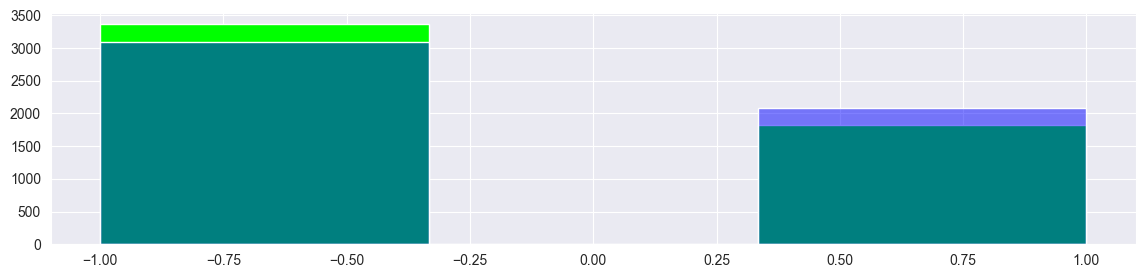

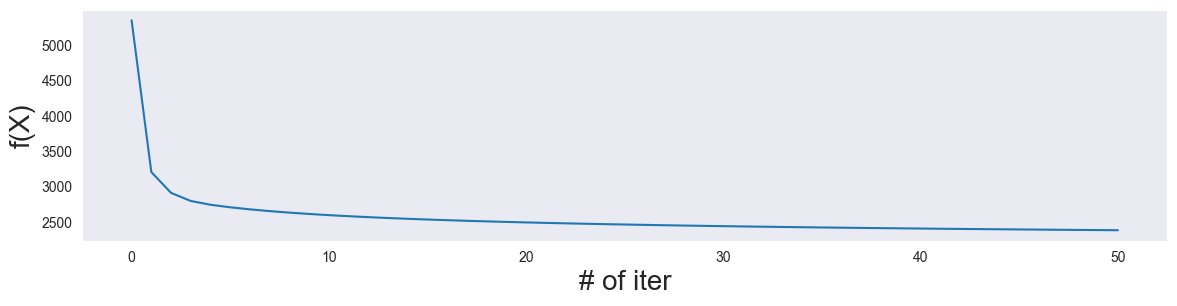

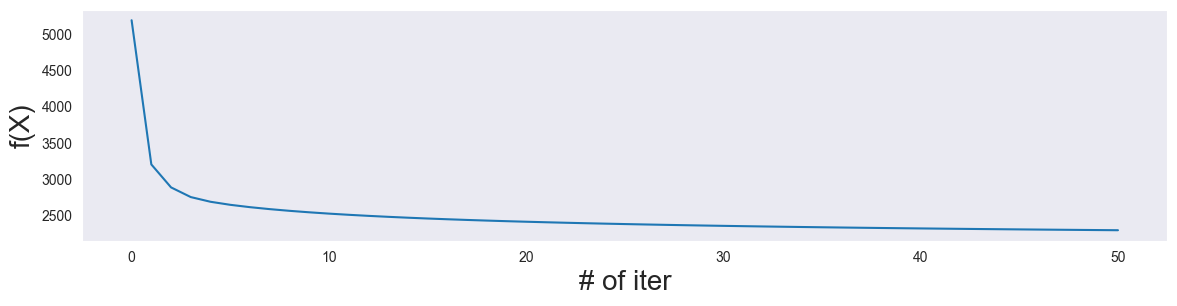

In [166]:
print(classification_report(test_target, best_model.predict(test_features.to_numpy())))
stat_visualize(best_model.predict(test_features.to_numpy()), test_target)
best_model.visualize(test_features.to_numpy(), test_target.to_numpy())
best_sgd_model = best_model

### Сравнение коэффициентов с библиотекой

In [167]:
best_model.theta_not_weights[-1]

array([ 1.31708496e-01,  1.15701028e-04,  2.62305562e-01, -2.13003150e-01,
        6.02817683e-01,  2.59265186e-03, -9.95182686e-02,  3.19452068e-01,
        1.31314813e-01,  5.20683110e-01,  1.07912990e+00, -1.60316470e-01,
        2.94890941e-01,  1.26739413e+00,  6.72052308e-01])

# SVD + L2

## Библиотечный svd классификатор с l2 регуляризацией

In [168]:
from sklearn.linear_model import RidgeClassifier

models = {}

def objective(trial: optuna.Trial):
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    alpha = trial.suggest_float('alpha', 0.0, 10.)
    model = RidgeClassifier(alpha=alpha, class_weight=class_weight, solver='svd').fit(train_features.to_numpy(), train_target.to_numpy())
    models[trial.number] = model
    y_pred = model.predict(val_features.to_numpy())
    score = roc_auc_score(val_target, y_pred, average='weighted')
    return 1. - score

study = optuna.create_study()
study.optimize(objective, 
               timeout=60,
               # n_jobs=-1,
               )

best_model = models[study.best_trial.number]
study.best_params

[I 2024-05-21 07:47:08,461] A new study created in memory with name: no-name-f7ba0f92-b59d-454c-a810-76ad6ee773f7
[I 2024-05-21 07:47:08,507] Trial 0 finished with value: 0.14342278968738253 and parameters: {'class_weight': None, 'alpha': 8.934853914467046}. Best is trial 0 with value: 0.14342278968738253.
[I 2024-05-21 07:47:08,515] Trial 1 finished with value: 0.14342278968738253 and parameters: {'class_weight': None, 'alpha': 9.036680813682384}. Best is trial 0 with value: 0.14342278968738253.
[I 2024-05-21 07:47:08,521] Trial 2 finished with value: 0.14342278968738253 and parameters: {'class_weight': None, 'alpha': 8.38770609547122}. Best is trial 0 with value: 0.14342278968738253.
[I 2024-05-21 07:47:08,528] Trial 3 finished with value: 0.14462638252473392 and parameters: {'class_weight': None, 'alpha': 4.429458424197755}. Best is trial 0 with value: 0.14342278968738253.
[I 2024-05-21 07:47:08,535] Trial 4 finished with value: 0.13224122514141867 and parameters: {'class_weight': '

{'class_weight': 'balanced', 'alpha': 7.734381970964027}

              precision    recall  f1-score   support

          -1       0.93      0.87      0.90      3364
           1       0.78      0.88      0.83      1826

    accuracy                           0.87      5190
   macro avg       0.86      0.87      0.86      5190
weighted avg       0.88      0.87      0.87      5190


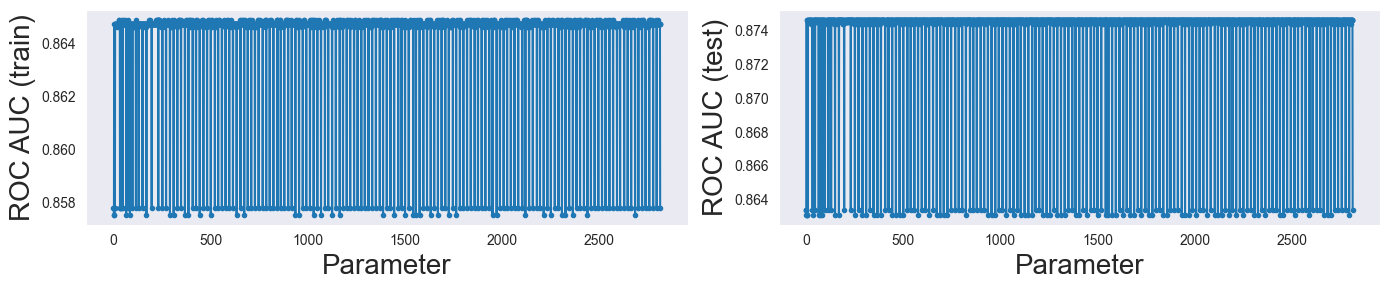

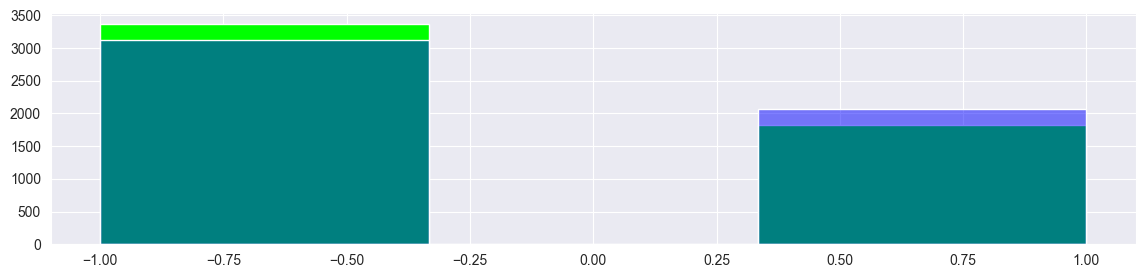

In [169]:
plot_roc_auc(list(models.values()))
print(classification_report(test_target, best_model.predict(test_features.to_numpy())))
stat_visualize(best_model.predict(test_features.to_numpy()), test_target)

## Самодельный svd классификатор

In [170]:
class DIYLeastSquareClassifier:
    def __init__(self):
        self.theta_not_weights = None
    
    def fit(self, X, Y):
        
        v, s, u_T = np.linalg.svd(X)
        u = u_T.T
        
        d_inv = np.diag(1. / s)
        d_inv.resize(X.shape,refcheck=False)
        d_inv = d_inv.T
        
        self.theta_not_weights = u @ d_inv @ v.T @ Y

        return self
        
    def predict(self, X):
        return 2 * ((np.dot(X, self.theta_not_weights)) >= 0) - 1


              precision    recall  f1-score   support

          -1       0.94      0.83      0.88      3364
           1       0.75      0.91      0.82      1826

    accuracy                           0.86      5190
   macro avg       0.84      0.87      0.85      5190
weighted avg       0.87      0.86      0.86      5190

1 - Roc Auc: 0.13366500495060904


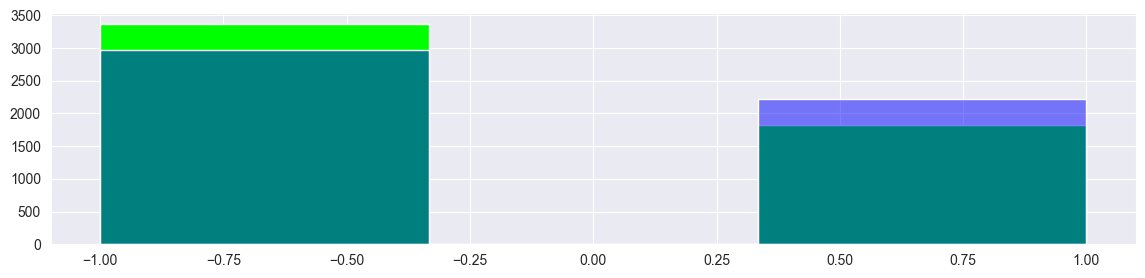

In [171]:
model = DIYLeastSquareClassifier().fit(train_features.to_numpy(), train_target.to_numpy())
print(classification_report(test_target, model.predict(test_features.to_numpy())))
print("1 - Roc Auc:", roc_auc_score(val_target, 1. - model.predict(val_features.to_numpy()), average='weighted'))
stat_visualize(model.predict(test_features.to_numpy()), test_target)

## Самодельный SVD классификатор с l2 регуляризацией

In [172]:
class DIYRidgeClassifier:
    def __init__(self, tau=0.0):
        self.theta_not_weights = None
        self.tau = tau
        self.target_function = None
    
    def fit(self, X, Y):
        v, s, u_T = np.linalg.svd(X)
        d = np.diag(s)
        d.resize(X.shape, refcheck=False)
        u = u_T.T

        d_ridged_inv = np.diag(s / ((s * s) + self.tau))
        d_ridged_inv.resize(X.shape,refcheck=False)
        d_ridged_inv = d_ridged_inv.T
        
        self.theta_not_weights = u @ d_ridged_inv @ v.T @ Y

        # Lτ (θ) = ‖F θ − y‖^2 + τ ‖θ‖^2
        self.target_function = (np.linalg.norm(X @ self.theta_not_weights - Y) ** 2) + self.tau * (np.linalg.norm(self.theta_not_weights) ** 2)

        return self
        
    def predict(self, X):
        return 2 * ((np.dot(X, self.theta_not_weights)) >= 0) - 1

DIYRidgeClassifier().fit(train_features.to_numpy(), train_target.to_numpy())

In [173]:
models = {}

def objective(trial: optuna.Trial):
    tau = trial.suggest_float('tau', 0.0, 1000.)
    
    model = DIYRidgeClassifier(tau=tau).fit(train_features.to_numpy(), train_target.to_numpy())
    models[trial.number] = model
    y_pred = model.predict(val_features.to_numpy())
    score = roc_auc_score(val_target, y_pred, average='weighted')
    return 1. - score

study = optuna.create_study()
study.optimize(objective, 
               timeout=30,
               n_jobs=20,
               )

best_model = models[study.best_trial.number]
study.best_params

[I 2024-05-21 07:48:17,942] A new study created in memory with name: no-name-0da6f5c9-71d2-4aac-94d9-ce0934cc253f
[I 2024-05-21 07:48:23,784] Trial 15 finished with value: 0.13255927298963055 and parameters: {'tau': 676.0333498092863}. Best is trial 15 with value: 0.13255927298963055.
[I 2024-05-21 07:48:23,792] Trial 5 finished with value: 0.133208800571047 and parameters: {'tau': 77.85618242379111}. Best is trial 15 with value: 0.13255927298963055.
[I 2024-05-21 07:48:23,792] Trial 4 finished with value: 0.13255927298963055 and parameters: {'tau': 671.3705412720077}. Best is trial 15 with value: 0.13255927298963055.
[I 2024-05-21 07:48:23,793] Trial 1 finished with value: 0.13143819030294657 and parameters: {'tau': 180.8799021878269}. Best is trial 1 with value: 0.13143819030294657.
[I 2024-05-21 07:48:23,794] Trial 14 finished with value: 0.13161856132998695 and parameters: {'tau': 366.11749664608686}. Best is trial 1 with value: 0.13143819030294657.
[I 2024-05-21 07:48:23,795] Tria

{'tau': 202.11076059989935}

              precision    recall  f1-score   support

          -1       0.94      0.83      0.88      3364
           1       0.75      0.91      0.82      1826

    accuracy                           0.86      5190
   macro avg       0.84      0.87      0.85      5190
weighted avg       0.87      0.86      0.86      5190


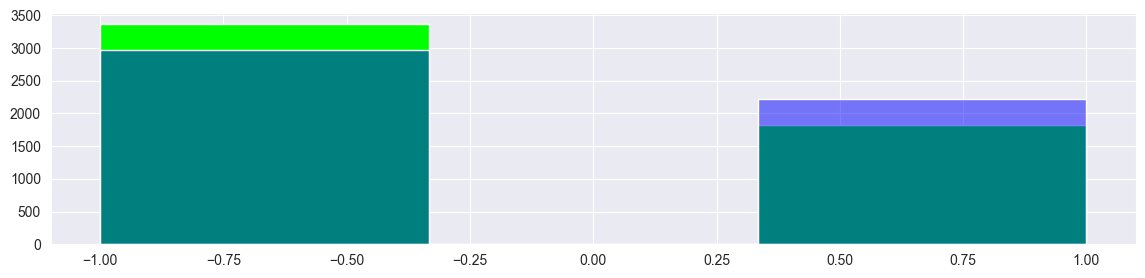

In [174]:
print(classification_report(test_target, best_model.predict(test_features.to_numpy())))
stat_visualize(best_model.predict(test_features.to_numpy()), test_target)

In [175]:
best_model.theta_not_weights

array([ 0.04845656, -0.07050479,  0.04087912, -0.02329946,  0.12504803,
        0.01789699, -0.01957713,  0.11157952,  0.00279077,  0.10800551,
        0.33695075, -0.10347979,  0.06932859,  0.04736502,  0.30314867])

In [176]:
best_svd_model = best_model

# SVM

## Ядра

In [177]:
def polynomial_kernel(degree, coef0, gamma):  # при coef0=1, gamma=1 получаем "многочлен с мономиальной степенью <=d", при coef0=0, gamma=1 - "многочлен с мономиальной степенью =d", при coef0=0, gamma=1, degree=2 - "квадратичное"
    return lambda x, y: (gamma * np.dot(x, y) + coef0) ** degree

def sigmoid_kernel(gamma, coef0):  # при gamma=1, coef0=0 получаем "нейронные сети"
    return lambda x, y: np.tanh(gamma * np.dot(x, y) + coef0)

def svm_polynom_le_d(degree):
    return polynomial_kernel(degree, 1, 1)

def svm_polynom_eq_d(degree):
    return polynomial_kernel(degree, 0, 1)

def svm_quadratic():
    return polynomial_kernel(2, 0, 1)

def svm_nn():
    return sigmoid_kernel(1, 0)

## Библиотечный метод опорных векторов

In [178]:
from sklearn.svm import SVC

models = {}

def objective(trial: optuna.Trial):
    c = trial.suggest_float('C', 1e-12, 10.)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    kernel = trial.suggest_categorical('kernel', ['poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 2, 5)
    gamma = trial.suggest_float('gamma', 0.0, 1.)
    coef0 = trial.suggest_float('coef0', -10., 10.)
    model = SVC(C=c, kernel=kernel, degree=degree, gamma=gamma, coef0=coef0, class_weight=class_weight).fit(train_features.to_numpy(), train_target.to_numpy())
    models[trial.number] = model
    y_pred = model.predict(val_features.to_numpy())
    score = roc_auc_score(val_target, y_pred, average='weighted')
    return 1. - score

study = optuna.create_study()
study.optimize(objective, 
               timeout=60,
               n_jobs=-1,
               )

best_model = models[study.best_trial.number]
study.best_params

[I 2024-05-21 07:48:50,308] A new study created in memory with name: no-name-1053c02f-5a10-45cc-805f-5163c1427236
[I 2024-05-21 07:48:51,292] Trial 3 finished with value: 0.2100516551919992 and parameters: {'C': 5.04510808309165, 'class_weight': None, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 0.22063907206777922, 'coef0': -1.8524008229570335}. Best is trial 3 with value: 0.2100516551919992.
[I 2024-05-21 07:48:51,307] Trial 17 finished with value: 0.10586004359606094 and parameters: {'C': 0.4794160853930124, 'class_weight': 'balanced', 'kernel': 'poly', 'degree': 3, 'gamma': 0.027066859971760615, 'coef0': 0.43673994952102113}. Best is trial 17 with value: 0.10586004359606094.
[I 2024-05-21 07:48:51,708] Trial 12 finished with value: 0.25650966711951306 and parameters: {'C': 2.8810417519115887, 'class_weight': None, 'kernel': 'sigmoid', 'degree': 4, 'gamma': 0.6347131180053452, 'coef0': -8.175937362237274}. Best is trial 17 with value: 0.10586004359606094.
[I 2024-05-21 07:48:51,844] T

{'C': 2.1634524402538733,
 'class_weight': None,
 'kernel': 'rbf',
 'degree': 3,
 'gamma': 0.9059221248990961,
 'coef0': 0.9603827749584942}

              precision    recall  f1-score   support

          -1       0.96      0.95      0.96      3364
           1       0.91      0.93      0.92      1826

    accuracy                           0.94      5190
   macro avg       0.94      0.94      0.94      5190
weighted avg       0.95      0.94      0.94      5190


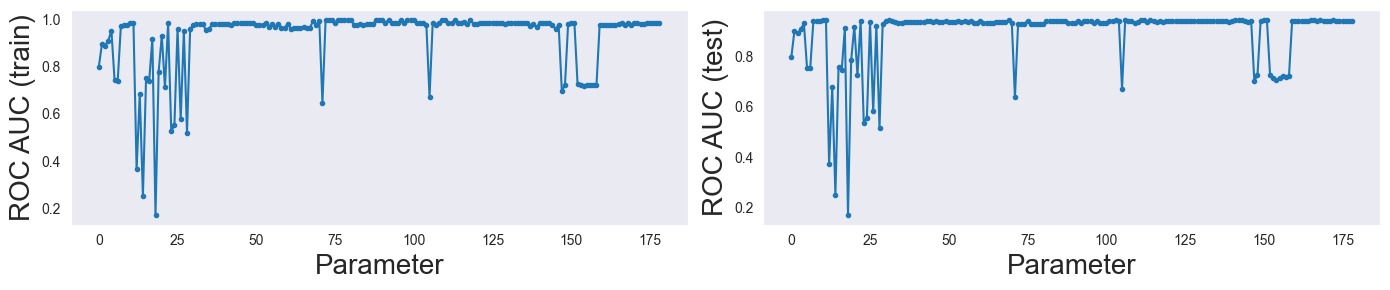

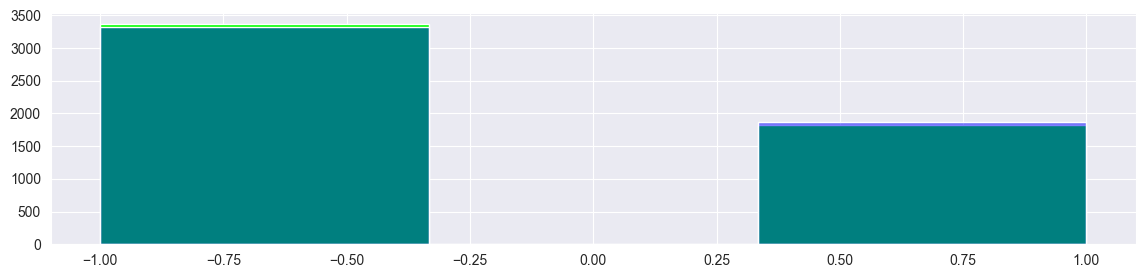

In [179]:
plot_roc_auc(list(models.values()))
print(classification_report(test_target, best_model.predict(test_features.to_numpy())))
stat_visualize(best_model.predict(test_features.to_numpy()), test_target)

In [180]:
best_model.dual_coef_.T

array([[-0.68497023],
       [-0.50024815],
       [-1.40055236],
       ...,
       [ 2.16345244],
       [ 0.99870887],
       [ 2.16345244]])

## Теория

![](data/svm.png)

![](data/min.png)

![](data/kkt.png)

![](data/lagrange.png)

![](data/support.png)

![](data/solution.png)

![](data/kernel_trick.png)

## Самодельный метод опорных векторов

In [209]:
class DIYSVC:
    def __init__(self, kernel=svm_polynom_eq_d(1), C=1.0, tol=1e-5, max_passes=5, max_iter=10):
        self.kernel = kernel
        self.C = C
        self.tol = tol
        self.max_passes = max_passes
        self.max_iter = max_iter
        self.kernel = kernel
        self.fit_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.X_train = X
        self.y = y
        self.alphas = np.zeros(n_samples)
        self.b = 0
        self.K = self.kernel(X, X.T)

        passes = 0
        iter = 0
        while passes < self.max_passes and iter < self.max_iter:
            num_changed_alphas = 0
            for i in range(n_samples):
                Ei = self._decision_function(X[i].reshape(1, -1)) - y[i]
                
                if (y[i]*Ei < -self.tol and self.alphas[i] < self.C) or (y[i]*Ei > self.tol and self.alphas[i] > 0):
                    j = np.random.choice([x for x in range(n_samples) if x != i])
                    Ej = self._decision_function(X[j].reshape(1, -1)) - y[j]

                    alpha_i_old = self.alphas[i]
                    alpha_j_old = self.alphas[j]

                    if y[i] != y[j]:
                        L = max(0, self.alphas[j] - self.alphas[i])
                        H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
                    else:
                        L = max(0, self.alphas[i] + self.alphas[j] - self.C)
                        H = min(self.C, self.alphas[i] + self.alphas[j])

                    if L == H:
                        continue

                    eta = 2 * self.K[i, j] - self.K[i, i] - self.K[j, j]
                    if eta >= 0:
                        continue

                    self.alphas[j] -= y[j] * (Ei[0] - Ej[0]) / eta
                    self.alphas[j] = np.clip(self.alphas[j], L, H)

                    if abs(self.alphas[j] - alpha_j_old) < 1e-5:
                        continue

                    self.alphas[i] += y[i] * y[j] * (alpha_j_old - self.alphas[j])

                    b1 = self.b - Ei - y[i] * (self.alphas[i] - alpha_i_old) * self.K[i, i] - y[j] * (self.alphas[j] - alpha_j_old) * self.K[i, j]
                    b2 = self.b - Ej - y[i] * (self.alphas[i] - alpha_i_old) * self.K[i, j] - y[j] * (self.alphas[j] - alpha_j_old) * self.K[j, j]

                    if 0 < self.alphas[i] < self.C:
                        self.b = b1
                    elif 0 < self.alphas[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2

                    num_changed_alphas += 1

            if num_changed_alphas == 0:
                passes += 1
            else:
                passes = 0

            iter += 1
            
            self.fit_history.append(self.alphas.copy())
            
        return self

    def _decision_function(self, X):
        K = self.kernel(X, self.X_train.T)
        return np.dot((self.alphas * self.y), K.T) + self.b

    def predict(self, X):
        return np.sign(self._decision_function(X))
    
    def get_optimize_history(self):
        N = len(self.X_train)
        L = []
        widths = []
        K = self.kernel(self.X_train, self.X_train.T)
    
        for alphas in self.fit_history:
            sum = 0.0
            wsum = np.zeros(self.X_train.shape[1])
            for i in range(N):
                wsum += alphas[i] * self.y[i] * self.X_train[i]
                for j in range(N):
                    sum += alphas[i] * alphas[j] * self.y[i] * self.y[j] * K[i, j]
            
            L.append(-np.sum(alphas) + 1 / 2 * sum)
            
            widths.append(1 / np.linalg.norm(wsum) ** 2)
        
        return np.asarray(L), widths
            

In [210]:
def objective(trial: optuna.Trial):
    c = trial.suggest_float('C', 1e-4, 100.)
    kernel = trial.suggest_categorical('kernel', ['linear', 'quad', 'poly_eq_d', 'poly_le_d', 'nn'])
    if kernel == 'linear':
        kernel = svm_polynom_eq_d(1)
    elif kernel == 'quad':
        kernel = svm_quadratic()
    elif kernel == 'poly_eq_d':
        degree = trial.suggest_int('degree', 2, 5)    
        kernel = svm_polynom_eq_d(degree)
    elif kernel == 'poly_le_d':
        degree = trial.suggest_int('degree', 1, 5)    
        kernel = svm_polynom_le_d(degree)
    elif kernel == 'nn':
        kernel = svm_nn()
    else:
        raise AssertionError()
    model = DIYSVC(max_passes=5, max_iter=10, kernel=kernel, C=c).fit(train_features.to_numpy(), train_target.to_numpy())
    models[trial.number] = model
    y_pred = model.predict(val_features.to_numpy())
    score = roc_auc_score(val_target, y_pred, average='weighted')
    return 1. - score

study = optuna.create_study()
study.optimize(objective, 
               timeout=60*60*2,
               n_jobs=-1,
               )

best_model = models[study.best_trial.number]
study.best_params

[I 2024-05-22 03:17:42,777] A new study created in memory with name: no-name-27a19a60-9deb-4f4f-a56b-c58434362388
[I 2024-05-22 03:22:14,992] Trial 14 finished with value: 0.30259398481813216 and parameters: {'C': 24.845942494460125, 'kernel': 'nn'}. Best is trial 14 with value: 0.30259398481813216.
[I 2024-05-22 03:22:22,847] Trial 7 finished with value: 0.2929863493671664 and parameters: {'C': 61.54380225996892, 'kernel': 'nn'}. Best is trial 7 with value: 0.2929863493671664.
[I 2024-05-22 03:22:23,125] Trial 0 finished with value: 0.2951997321298365 and parameters: {'C': 68.75803528376834, 'kernel': 'nn'}. Best is trial 7 with value: 0.2929863493671664.
[I 2024-05-22 03:24:22,084] Trial 11 finished with value: 0.13791523713033538 and parameters: {'C': 63.23067183676644, 'kernel': 'poly_le_d', 'degree': 2}. Best is trial 11 with value: 0.13791523713033538.
[I 2024-05-22 03:24:37,438] Trial 12 finished with value: 0.14123770982523198 and parameters: {'C': 18.49875414167214, 'kernel': 

{'C': 46.74300663758869, 'kernel': 'poly_le_d', 'degree': 5}

              precision    recall  f1-score   support

          -1       0.96      0.87      0.92      3364
           1       0.80      0.94      0.86      1826

    accuracy                           0.90      5190
   macro avg       0.88      0.91      0.89      5190
weighted avg       0.91      0.90      0.90      5190


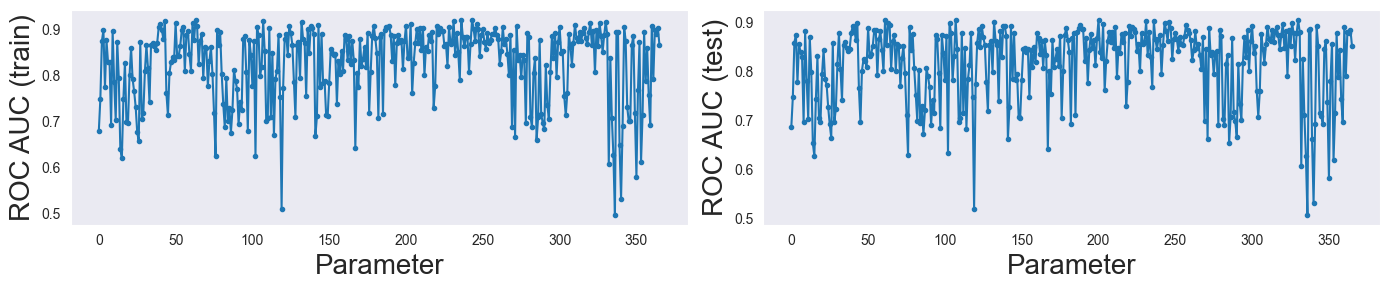

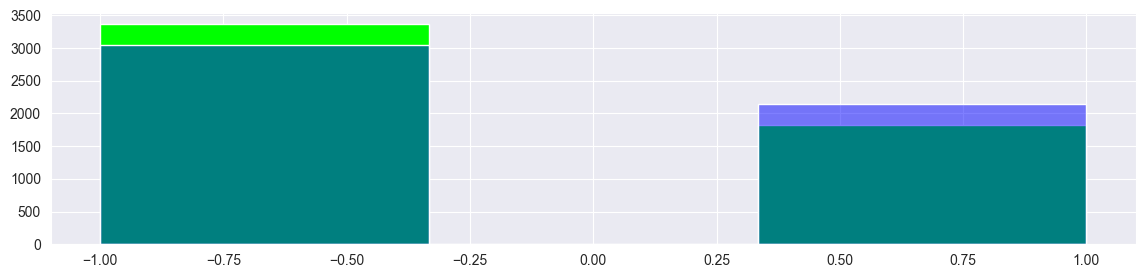

In [211]:
plot_roc_auc(list(models.values()))
print(classification_report(test_target, best_model.predict(test_features.to_numpy())))
stat_visualize(best_model.predict(test_features.to_numpy()), test_target)

In [212]:
best_model.alphas

array([0.00000000e+00, 0.00000000e+00, 2.25497011e-07, ...,
       6.91702003e-05, 9.91410498e-06, 1.19166574e-09])

In [213]:
best_svm_model = best_model

In [214]:
best_svm_model.get_optimize_history()[0]

array([-0.0120232 , -0.02024964, -0.03054683, -0.04171124, -0.05989216,
       -0.06855077, -0.07897855, -0.08815856, -0.09669554, -0.10445323])

# Сравнение "целевой функции"

Text(0, 0.5, 'f(X)')

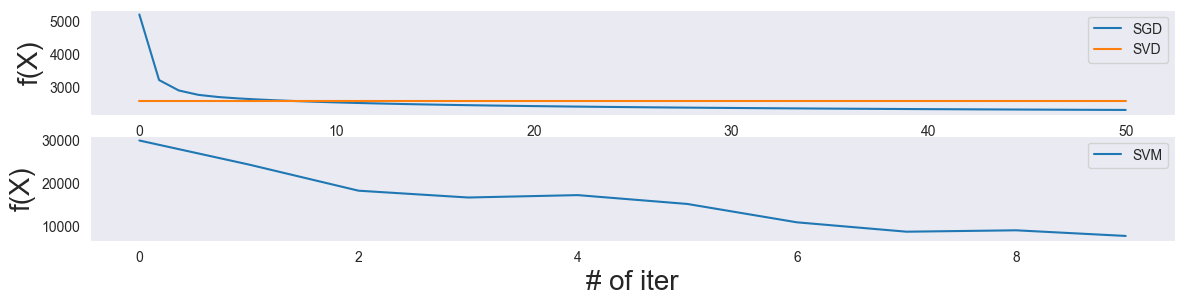

In [224]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot([sum([j(i) for j in best_sgd_model.loss(m_funcs(test_features.to_numpy(), test_target.to_numpy()))]) for i in np.array(best_sgd_model.theta_not_weights)])[0].set_label("SGD")
ax1.plot([best_svd_model.target_function for _ in range(len(best_sgd_model.theta_not_weights))])[0].set_label("SVD")
ax2.plot(best_svm_model.get_optimize_history()[1])[0].set_label("SVM")

ax1.grid()
ax1.legend()
ax1.set_xlabel("# of iter", fontsize=20)
ax1.set_ylabel("f(X)", fontsize=20)

ax2.grid()
ax2.legend()
ax2.set_xlabel("# of iter", fontsize=20)
ax2.set_ylabel("f(X)", fontsize=20)